___
# Challenger Model Set 1
___
- aim of this notebook is to understand the single models that work, and decide which model we should use to best capture the interactions between variables.

1. Base Models: RF, MLP, (KNN and Perceptron were tested but they do not model our data well)
2. Hyperparameter tuning with GridSearchCV
3. Attempted ways to improve our model:
    - Feature selection
    - Time Cut (train for 2010 onwards, test on before 2020; train, test split: 481880, 186099 rows)

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score, auc,
    precision_recall_curve, precision_recall_fscore_support,roc_curve
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from tqdm.auto               import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import recall_score, precision_score, f1_score, make_scorer
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import gc
gc.collect()

15

In [3]:
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from path_location import folder_location

___
## Toggle to run on full dataset

In [4]:
RUN_ON_SUBSET = False

___
# Load train and test dataset
___

In [5]:
PROCESSED_FOLDER = folder_location.PROCESSED_DATA_FOLDER
TRAINING_FILE = folder_location.TRAINING_FULL_FEATURES_FILE
TESTING_FILE = folder_location.TRAINING_FULL_FEATURES_FILE

In [6]:
TESTING_FEATURES_FILE = f"{PROCESSED_FOLDER}/{TESTING_FILE}"
TRAINING_FEATURES_FILE = f"{PROCESSED_FOLDER}/{TRAINING_FILE}"
COLS_TO_DROP = ['TRANS_SK','ACCESSION_NUMBER','ISSUERTRADINGSYMBOL','NODEID','RPTOWNERNAME_;',
                'snorkel_prob',
                "ppr_house_0.85", "ppr_house_0.95", "ppr_senate_0.85", "ppr_senate_0.95", "ppr_topK_exp"] 
LABEL = 'y_pred'

In [7]:
df_train = pd.read_csv(TESTING_FEATURES_FILE,parse_dates=['TRANS_DATE'])
df_test = pd.read_csv(TRAINING_FEATURES_FILE,parse_dates=['TRANS_DATE'])

print(df_train.shape)
print(df_test.shape)

df_train = df_train.drop(columns = COLS_TO_DROP )
df_test = df_test.drop(columns = COLS_TO_DROP )

if RUN_ON_SUBSET:
    df_train = df_train.sample(n=1000, random_state=5)  # Set random_state for reproducibility
    df_test = df_test.sample(n=100, random_state=5)  # Set random_state for reproducibility

# have a sorted version
df_train_sorted = df_train.sort_values(by='TRANS_DATE', ascending=True).reset_index(drop=True)
df_test_sorted = df_test.sort_values(by='TRANS_DATE', ascending=True).reset_index(drop=True)

(1417896, 111)
(1417896, 111)


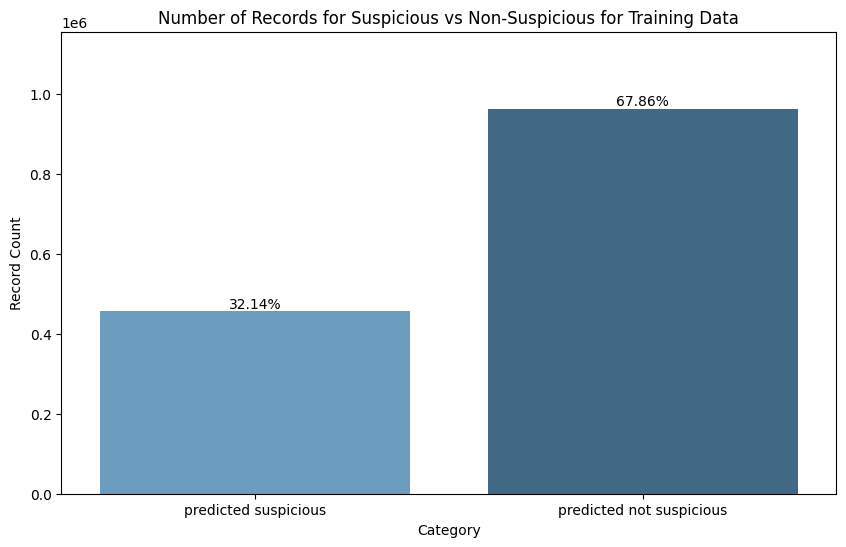

In [6]:
count1, count0 = sum(df_train[LABEL] == 1), sum(df_train[LABEL] == 0)

categories = ["predicted suspicious", "predicted not suspicious"]
value = [count1, count0]

plt.figure(figsize=(10,6))
# Create the barplot
ax = sns.barplot(x=categories, y=value, palette="Blues_d")
# Add percentage labels on top of the bars
for i, v in enumerate(value):
    ax.text(i, v + 0.01, f"{(v*100)/df_train.shape[0]:1.2f}%", ha='center', va='bottom')
plt.ylim(0, max(value) * 1.2)
plt.xlabel('Category')
plt.ylabel('Record Count')
plt.title('Number of Records for Suspicious vs Non-Suspicious for Training Data')
plt.show()

___
# Helper functions
___

In [8]:
# -----------------------------------------------------------------------------
# Helper: Make a pipeline with optional scaling
# -----------------------------------------------------------------------------
def make_pipe(clf, use_smote=False, scale=True, use_pca=False, pca_n = 0.9):
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    if use_pca:
        steps.append(("pca", PCA(n_components = pca_n)))
    if use_smote:
        steps.append(("smote", SMOTE(random_state=0)))
    steps.append(("clf", clf))
    return ImbPipeline(steps, verbose=False) if (use_smote or scale) else Pipeline(steps, verbose=False)

# -----------------------------------------------------------------------------
# Helper: Define custom time split
# -----------------------------------------------------------------------------

class DateGapTimeSeriesSplit:

    def __init__(self, date_col, train_period, gap_period, valid_period):
        self.date_col = date_col
        self.train_period = train_period
        self.gap_period = gap_period
        self.valid_period = valid_period

    def split(self, X, y=None, groups=None):
        dates = pd.to_datetime(X[self.date_col])
        start, end = dates.min(), dates.max()
        cur = start
        while True:
            train_end = cur + self.train_period
            gap_end   = train_end + self.gap_period
            val_end   = gap_end + self.valid_period
            if val_end > end:
                break
            train_mask = (dates >= cur) & (dates < train_end)
            val_mask   = (dates >= gap_end) & (dates < val_end)
            yield X.index[train_mask].to_numpy(), X.index[val_mask].to_numpy()
            cur = val_end

# --- 1) materialize your custom, gap‑aware folds ---
splitter   = DateGapTimeSeriesSplit(
    date_col    = "TRANS_DATE",
    train_period=pd.Timedelta("365 days"),
    gap_period  = pd.Timedelta("120 days"),
    valid_period=pd.Timedelta("365 days")
)

X_train_sorted_date = df_train_sorted.drop(columns = [LABEL])
CV_CUSTOM_SPLITS = list(splitter.split(X_train_sorted_date))  # list of (train_idx, val_idx)

# -----------------------------------------------------------------------------
# Helper: Find threshold to meet target recall
# -----------------------------------------------------------------------------
def find_threshold_for_recall(y_true, probs, target_recall=0.75, num_steps=200):
    thresholds = np.linspace(0, 1, num_steps)
    best_thr, best_diff = 0.5, float("inf")
    for thr in thresholds:
        y_pred = (probs >= thr).astype(int)
        _, rec, _, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        diff = abs(rec - target_recall)
        if diff < best_diff:
            best_diff, best_thr = diff, thr
    return best_thr

# -----------------------------------------------------------------------------
# Helper: Plot precision-recall curve
# -----------------------------------------------------------------------------

def plot_precision_recall_curve(y_test, y_probs, title):
    # Compute precision-recall pairs
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, y_probs)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    print("Area under PR curvere:", round(pr_auc,3))
    print("Average precision score:", round(avg_precision,3))
    print("Area under ROC curve", round(roc_auc,3)) 

    # Create side-by-side plots
    _, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Precision-Recall curve
    axs[0].plot(recall, precision, color='blue', label=f"PR AUC = {pr_auc:.4f}")
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"Precision-Recall Curve {title}")
    axs[0].grid(True)
    axs[0].legend()

    # Plot ROC curve
    axs[1].plot(fpr, tpr, color='green', label=f"ROC AUC = {roc_auc:.4f}")
    axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title(f"ROC Curve {title}")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# Helper: Get evalutaion metrics (classification report for best threshold and plot curves)
# -----------------------------------------------------------------------------
def get_eval_metrics(y_true, y_probs, title, target_recall=0.75):
    # Find the best threshold for the target recall
    best_thr = find_threshold_for_recall(y_true, y_probs, target_recall)

    print(f"Best threshold for recall {target_recall}: {best_thr:.4f}")
    y_pred = (y_probs >= best_thr).astype(int)

    print("\n=== Classification Report ===")
    print(f"\nThreshold for recall={target_recall} ⇒ {best_thr:.3f}")
    print(classification_report(y_true, y_pred, digits=3))

    plot_precision_recall_curve(y_true, y_probs, title)
    
# -----------------------------------------------------------------------------
# Plot: Feature Importance for Random Forest
# -----------------------------------------------------------------------------
def plot_feature_importance(pipe, X, title):
    model = pipe.named_steps['clf']
    n = len(X.columns)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:n]

    plt.figure(figsize=(15, 20))
    plt.barh(range(n), importances[indices][::-1], align='center')
    plt.yticks(range(n), [X.columns[i] for i in indices][::-1])
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance {title}")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# Helper: Plot permutation importance for MLP
# -----------------------------------------------------------------------------
def plot_permutation_importance(pipe, X_test, y_test, title):
    # Compute permutation importance
    print("Computing permutation importance")
    result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42)
    # Create a DataFrame for better visualization
    importances_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values(by='importance', ascending=False)

    print("Top 10 features by permutation importance:")
    print(importances_df.head(10))

    # Plot the feature importances
    plt.figure(figsize=(15, 20))
    plt.barh(importances_df['feature'], importances_df['importance'], xerr=importances_df['std'])
    plt.xlabel("Mean Importance (Decrease in Score)")
    plt.title(f"Permutation Importance {title}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

___
# 1. Base Model
___
### Create X_train, y_train, X_test, y_test 

In [8]:
# for base models:
X_train, y_train = df_train.drop(columns = [LABEL] + ['TRANS_DATE']), df_train[LABEL]
X_test, y_test = df_test.drop(columns = [LABEL] + ['TRANS_DATE']), df_test[LABEL]

X_train_sorted, y_train_sorted = df_train_sorted.drop(columns = [LABEL] + ['TRANS_DATE']), df_train_sorted[LABEL]
X_test_sorted, y_test_sorted = df_test_sorted.drop(columns = [LABEL] + ['TRANS_DATE']), df_test_sorted[LABEL]

___
## 1.1 Base Model: RandomForestClassifier
___

Best threshold for recall 0.75: 0.4121

=== Classification Report ===

Threshold for recall=0.75 ⇒ 0.412
              precision    recall  f1-score   support

           0      0.734     0.437     0.548    213483
           1      0.454     0.747     0.565    133537

    accuracy                          0.556    347020
   macro avg      0.594     0.592     0.556    347020
weighted avg      0.626     0.556     0.554    347020

Area under PR curvere: 0.506
Average precision score: 0.504
Area under ROC curve 0.635


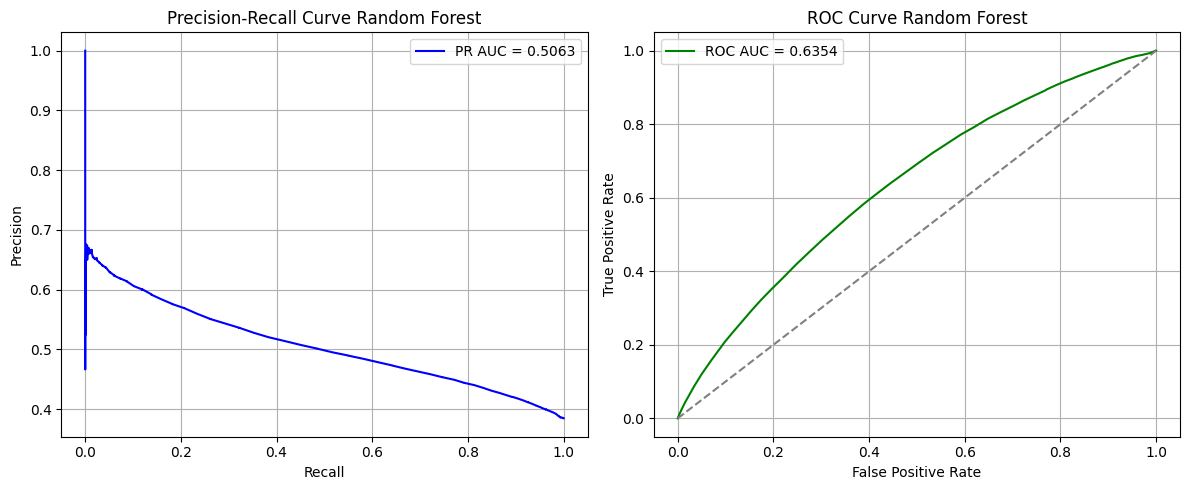

In [9]:
# -----------------------------------------------------------------------------
# Train RF Forest
# -----------------------------------------------------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipe = make_pipe(rf)
rf_pipe.fit(X_train, y_train)
y_probs_rf = rf_pipe.predict_proba(X_test)[:, 1]
get_eval_metrics(y_test, y_probs_rf, "Random Forest", target_recall=0.75)

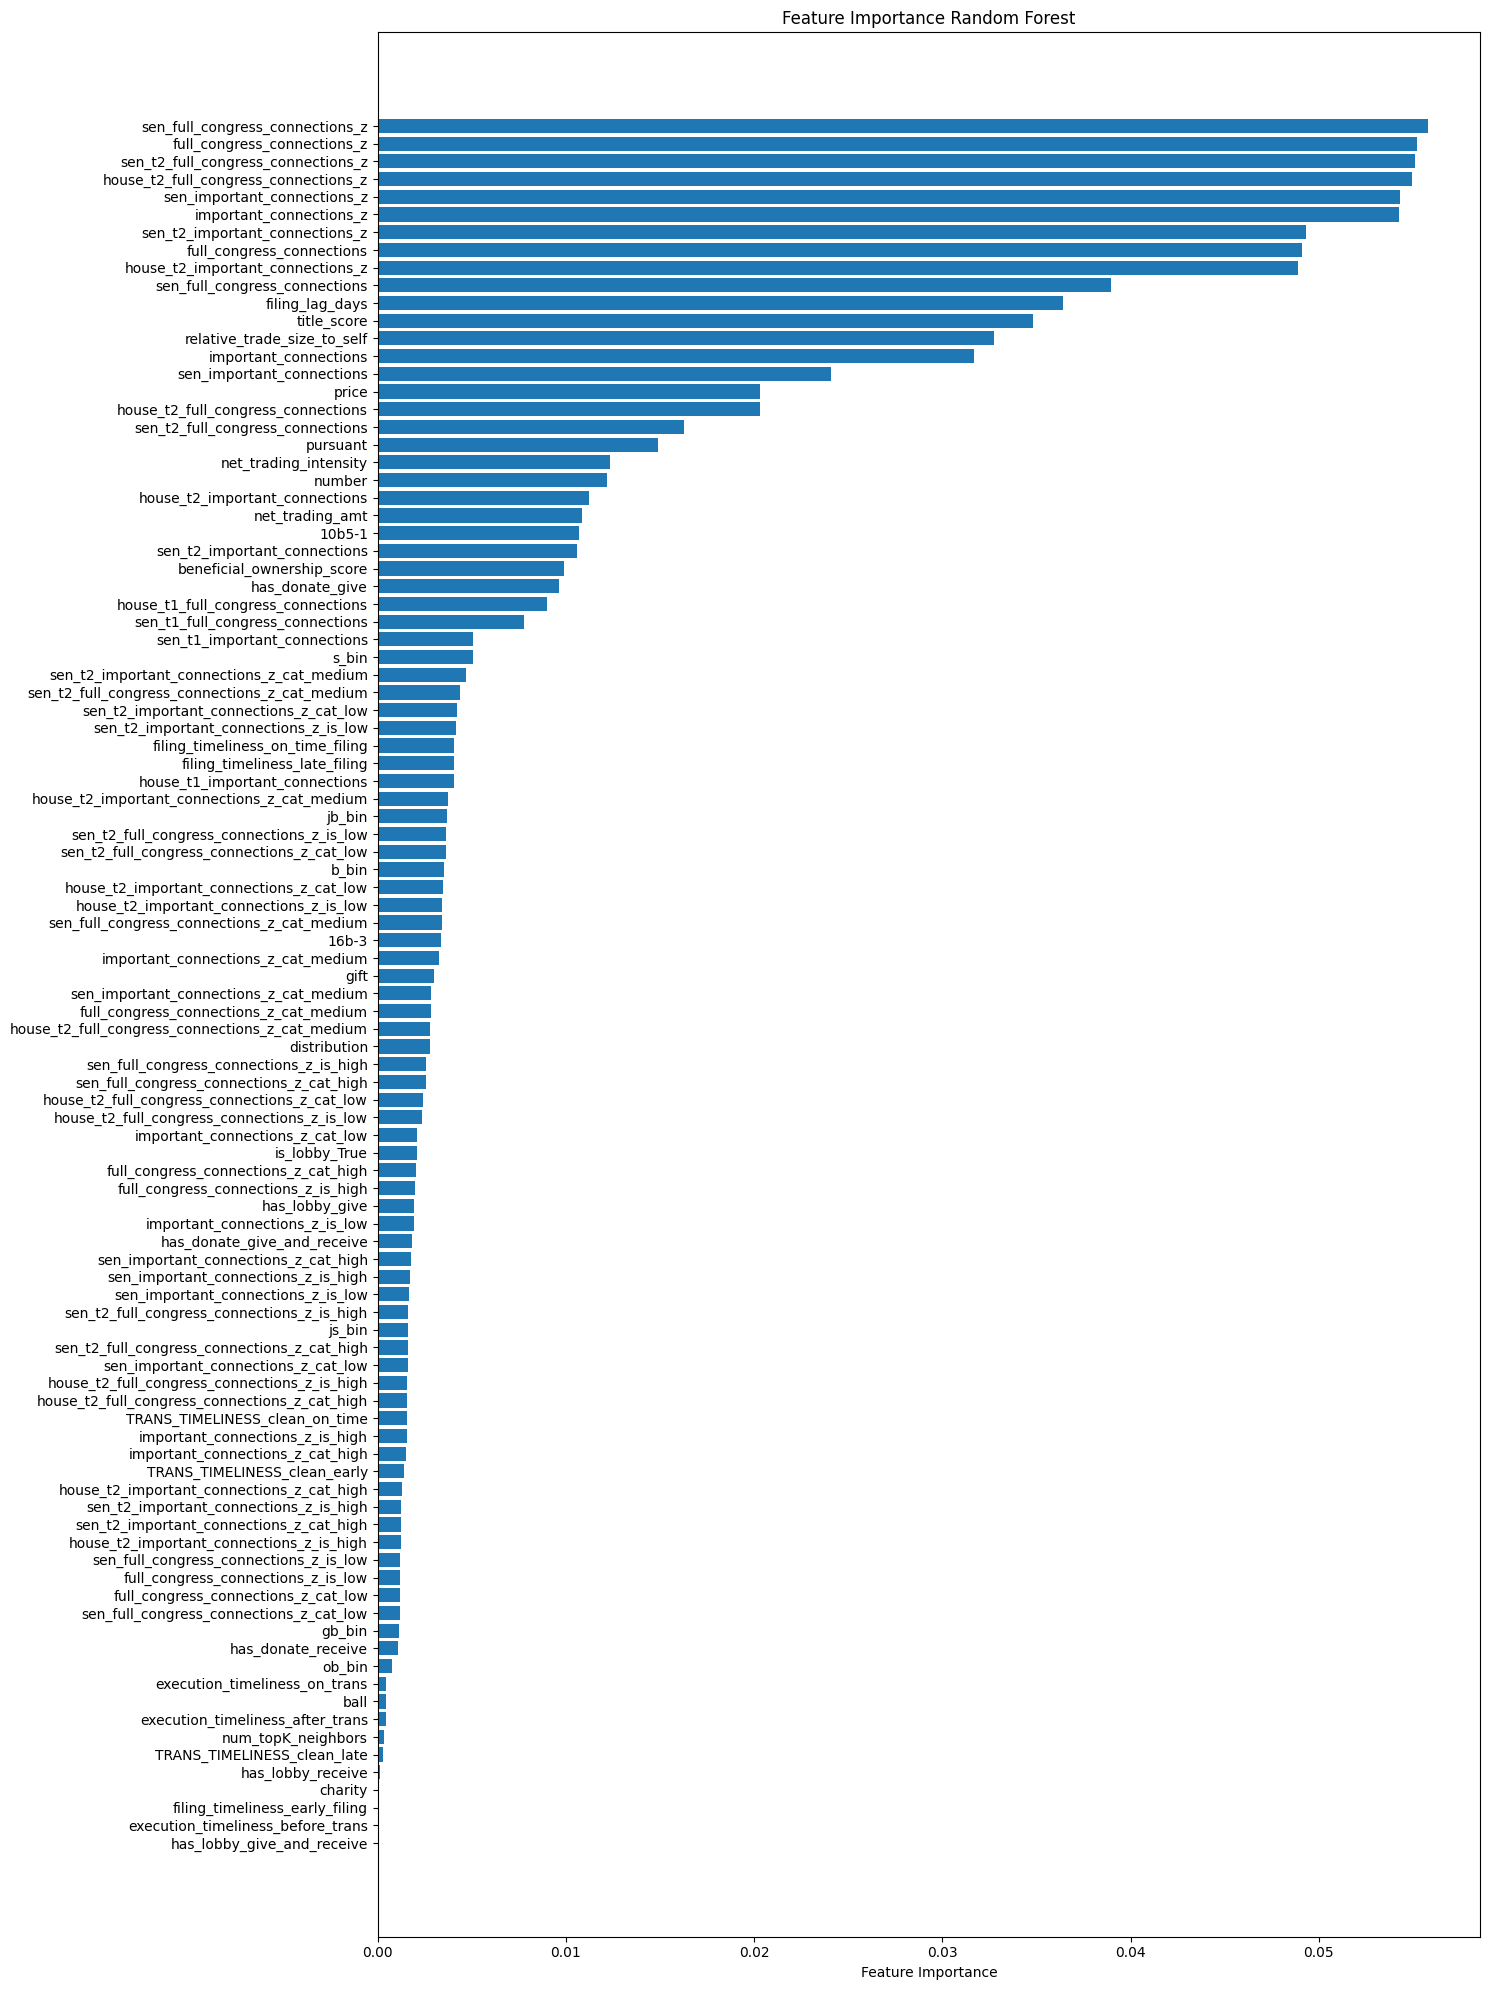

In [10]:
plot_feature_importance(rf_pipe, X_test, title="Random Forest")

___
## 1.2 Base Model: Perceptron
___

Best threshold for recall 0.75: 0.3668

=== Classification Report ===

Threshold for recall=0.75 ⇒ 0.367
              precision    recall  f1-score   support

           0      0.705     0.355     0.472    213483
           1      0.425     0.762     0.546    133537

    accuracy                          0.512    347020
   macro avg      0.565     0.559     0.509    347020
weighted avg      0.597     0.512     0.501    347020

Area under PR curvere: 0.452
Average precision score: 0.453
Area under ROC curve 0.59


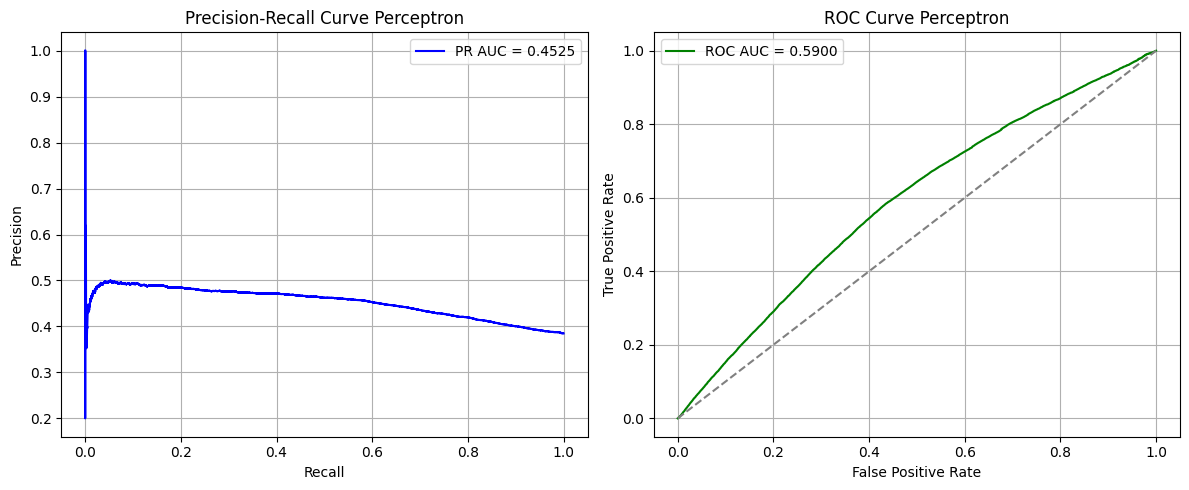

Computing permutation importance
Top 10 features by permutation importance:
                             feature    importance           std
43                              gift  1.181488e-05  2.017175e-06
45                           charity  1.181488e-05  8.645035e-07
44                      distribution  1.095038e-05  1.152671e-06
2          full_congress_connections  2.305343e-06  3.822978e-06
39                             b_bin  1.152671e-06  1.411728e-06
14   sen_full_congress_connections_z  8.645035e-07  3.656440e-06
38                             s_bin  8.645035e-07  1.845174e-06
7          sen_important_connections  2.881678e-07  2.017175e-06
92  execution_timeliness_after_trans  2.881678e-07  8.645035e-07
50                            10b5-1  2.881678e-07  1.551831e-06


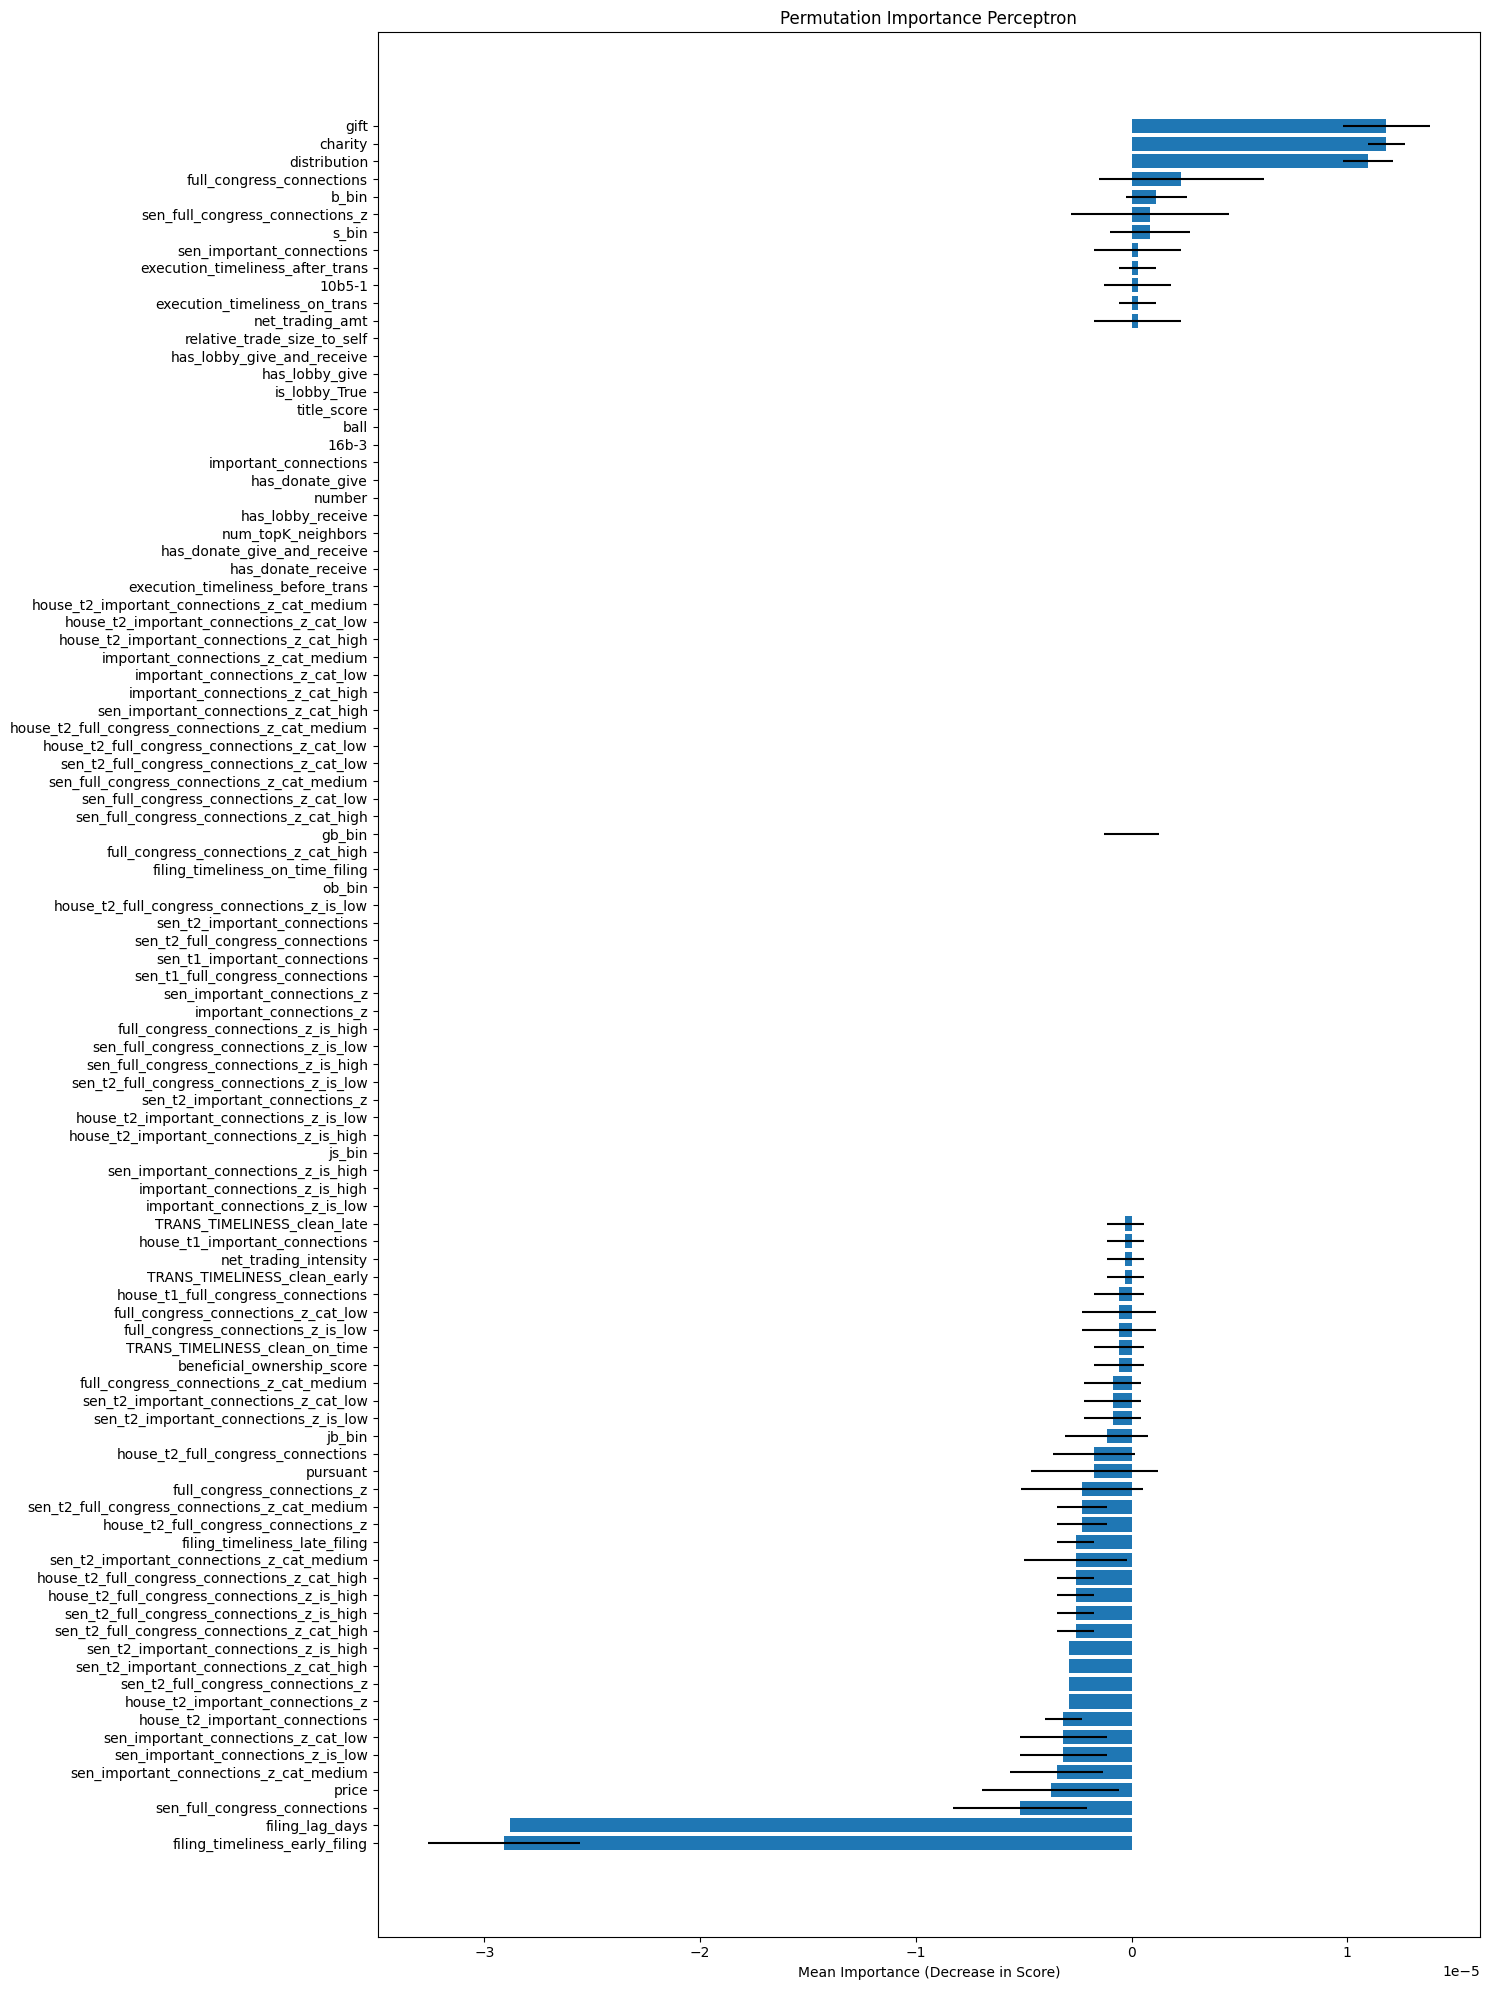

In [11]:
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
# -----------------------------------------------------------------------------
# Model: Perceptron with calibrated probabilities
# -----------------------------------------------------------------------------
base_model = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
calibrated = CalibratedClassifierCV(base_model, 
                                    method='sigmoid', 
                                    cv=CV_CUSTOM_SPLITS)

perceptron_pipe = make_pipe(calibrated, scale=True) 

perceptron_pipe.fit(X_train_sorted, y_train_sorted)

y_prob_ppt = perceptron_pipe.predict_proba(X_test_sorted)[:, 1]

get_eval_metrics(y_test_sorted, y_prob_ppt, "Perceptron", target_recall=0.75)

plot_permutation_importance(perceptron_pipe, X_test_sorted, y_test_sorted, title="Perceptron")

___
## 1.3 Base Model: MLP
___

Iteration 1, loss = 0.63463970
Validation score: 0.657441
Iteration 2, loss = 0.59643795
Validation score: 0.680212
Iteration 3, loss = 0.57684351
Validation score: 0.691166
Iteration 4, loss = 0.56444880
Validation score: 0.699023
Iteration 5, loss = 0.55538473
Validation score: 0.705586
Iteration 6, loss = 0.54853517
Validation score: 0.710101
Iteration 7, loss = 0.54313108
Validation score: 0.713697
Iteration 8, loss = 0.53864895
Validation score: 0.716758
Iteration 9, loss = 0.53489043
Validation score: 0.719044
Iteration 10, loss = 0.53165174
Validation score: 0.722100
Iteration 11, loss = 0.52886079
Validation score: 0.723970
Iteration 12, loss = 0.52638714
Validation score: 0.726719
Iteration 13, loss = 0.52402374
Validation score: 0.728174
Iteration 14, loss = 0.52191897
Validation score: 0.729806
Iteration 15, loss = 0.52003633
Validation score: 0.731126
Iteration 16, loss = 0.51830152
Validation score: 0.732482
Iteration 17, loss = 0.51662340
Validation score: 0.733339
Iterat

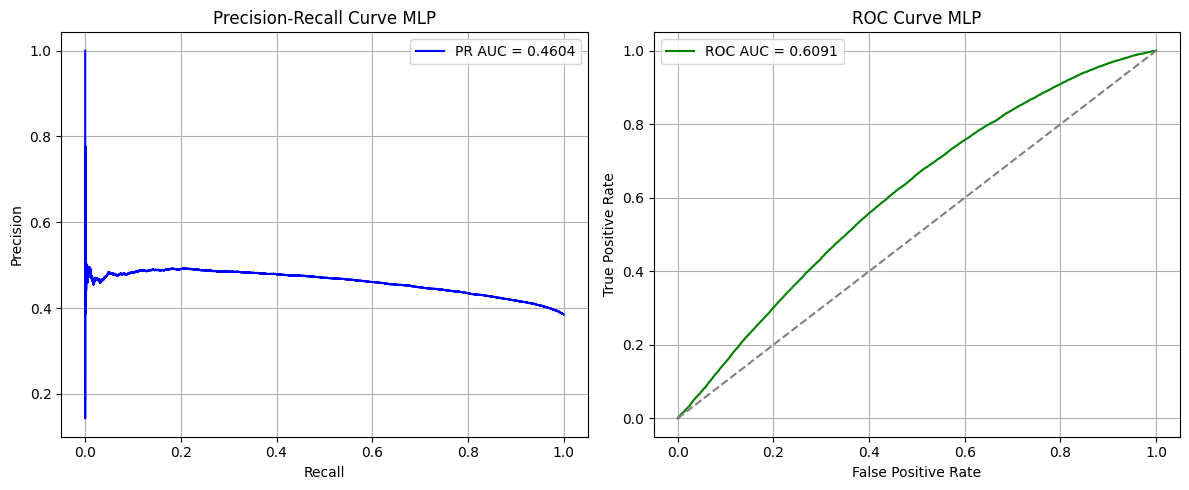

In [12]:
mlp_pipe = make_pipe(MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        batch_size=1024,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-3,
        random_state=0,
        verbose=True,
        shuffle=False, ), 
    use_smote=True,
    scale=True)

mlp_pipe.fit(X_train_sorted, y_train_sorted)

# -----------------------------------------------------------------------------
# Predict probabilities
# -----------------------------------------------------------------------------
y_probs_mlp = mlp_pipe.predict_proba(X_test_sorted)[:, 1]

get_eval_metrics(y_test_sorted, y_probs_mlp, "MLP", target_recall=0.75)

Computing permutation importance
Top 10 features by permutation importance:
                                    feature  importance       std
46                                    price    0.018354  0.000423
39                                    b_bin    0.018190  0.000568
56                              title_score    0.009596  0.000399
47                                   number    0.009343  0.000556
62                          has_donate_give    0.008899  0.000395
40                                   jb_bin    0.007629  0.000194
49                                 pursuant    0.007041  0.000431
29       sen_important_connections_z_is_low    0.007023  0.000218
50                                   10b5-1    0.006460  0.000391
24  sen_full_congress_connections_z_is_high    0.004612  0.000265


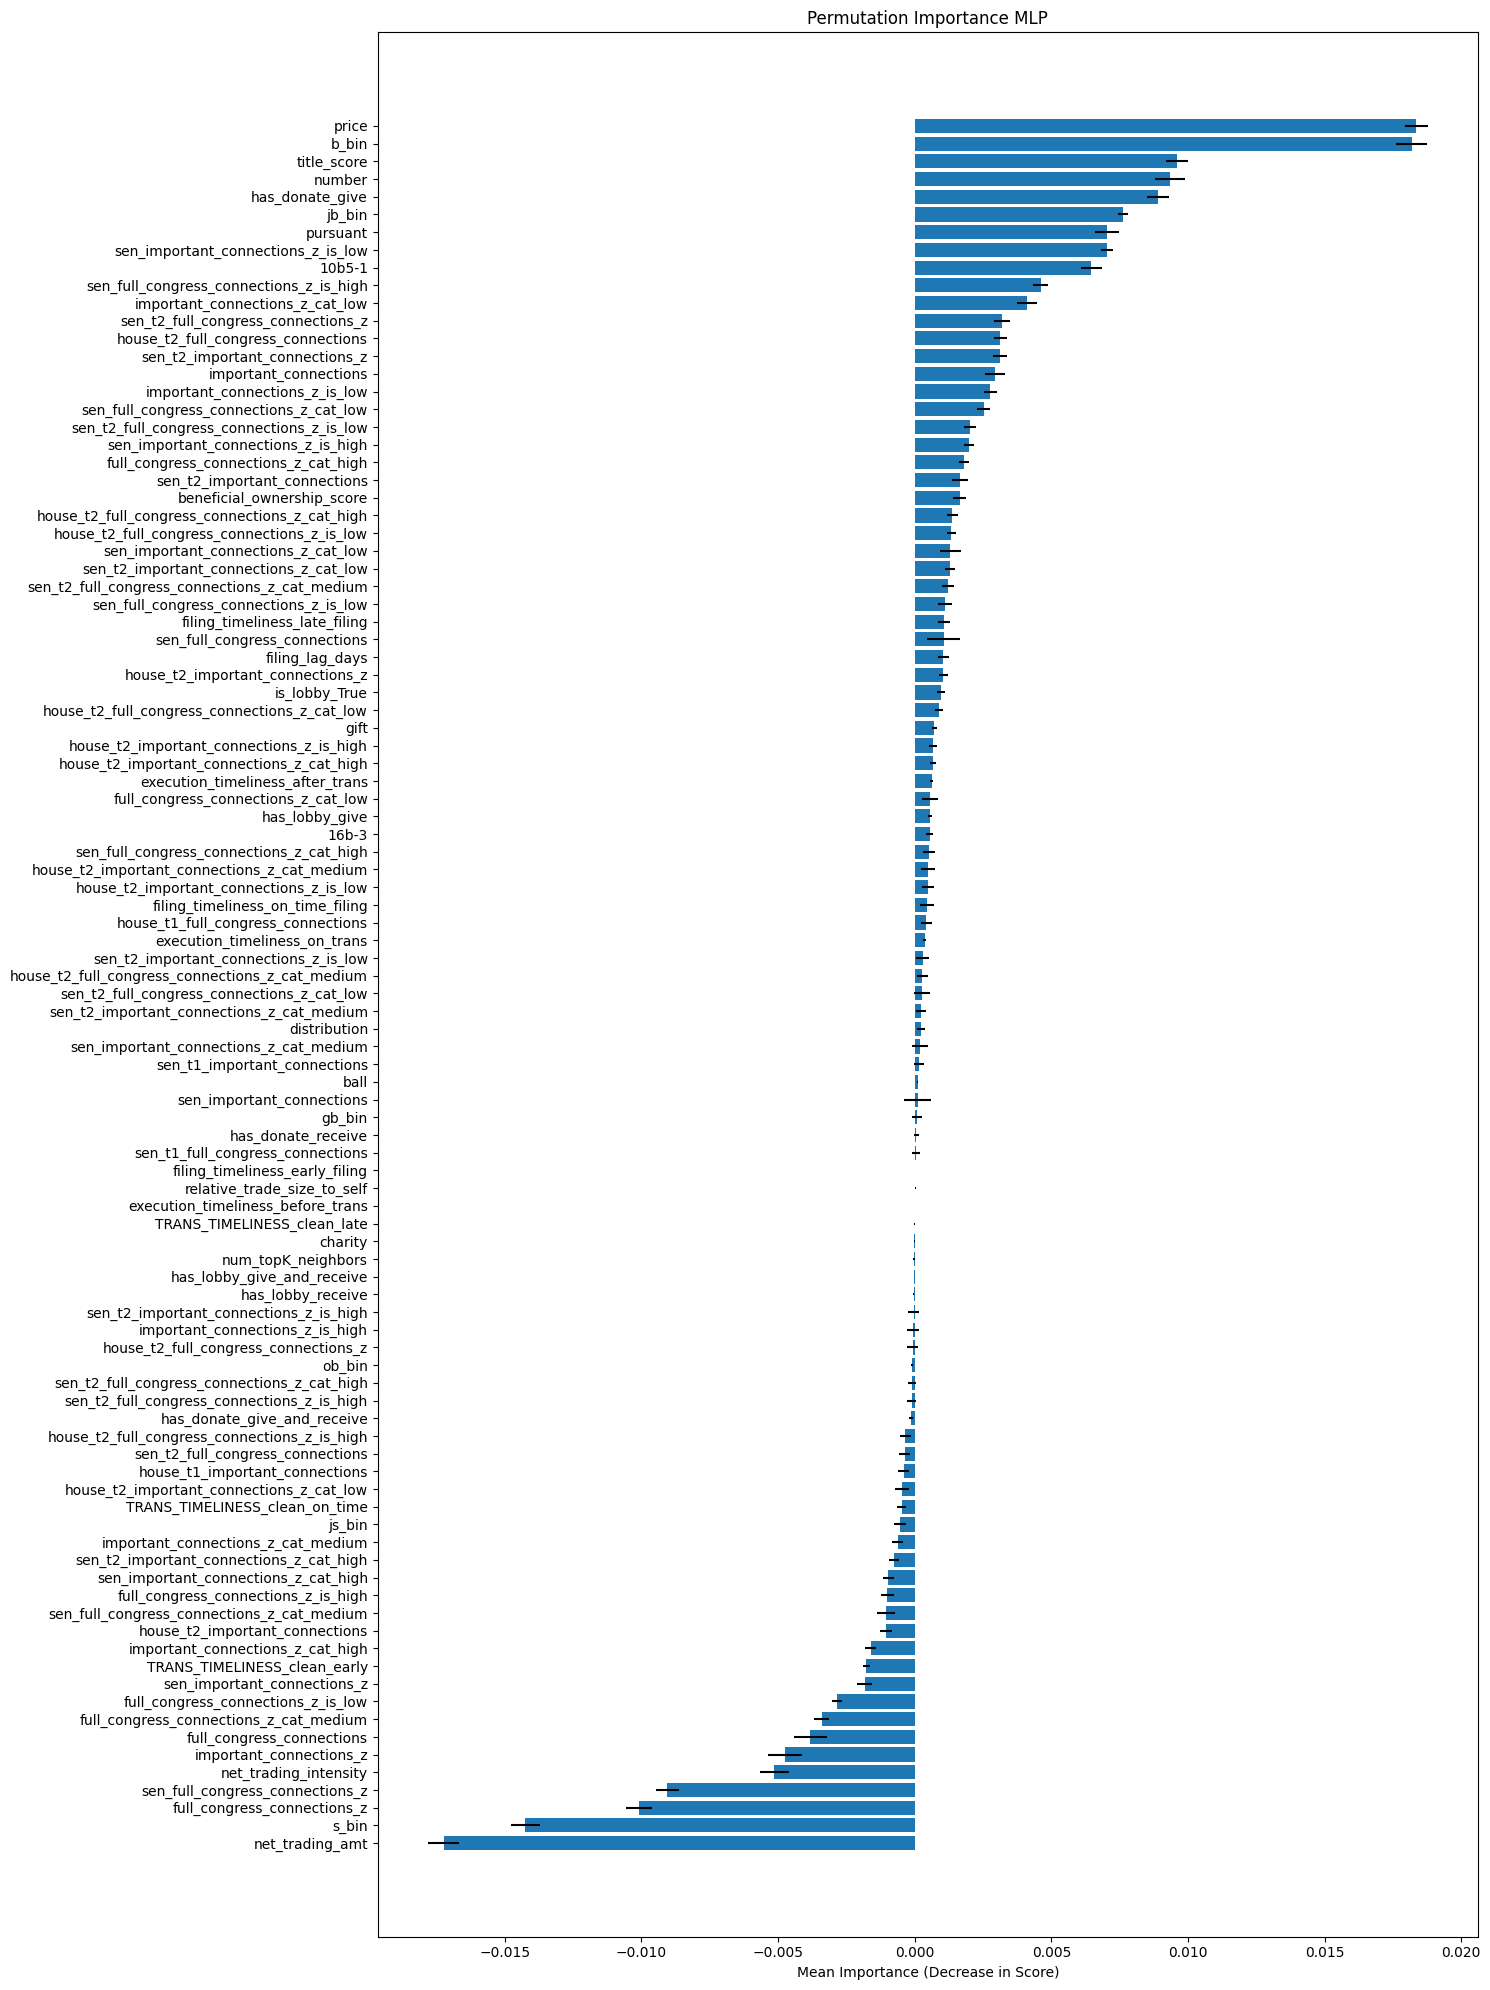

In [13]:
plot_permutation_importance(mlp_pipe, X_test_sorted, y_test_sorted, "MLP")

___
## 2. Hyperparameter tuning: RandomForest
___

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=   4.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time= 2.3min
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  33.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  34.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  29.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=200; total time=   8.2s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=200; total time= 4.5min
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf_

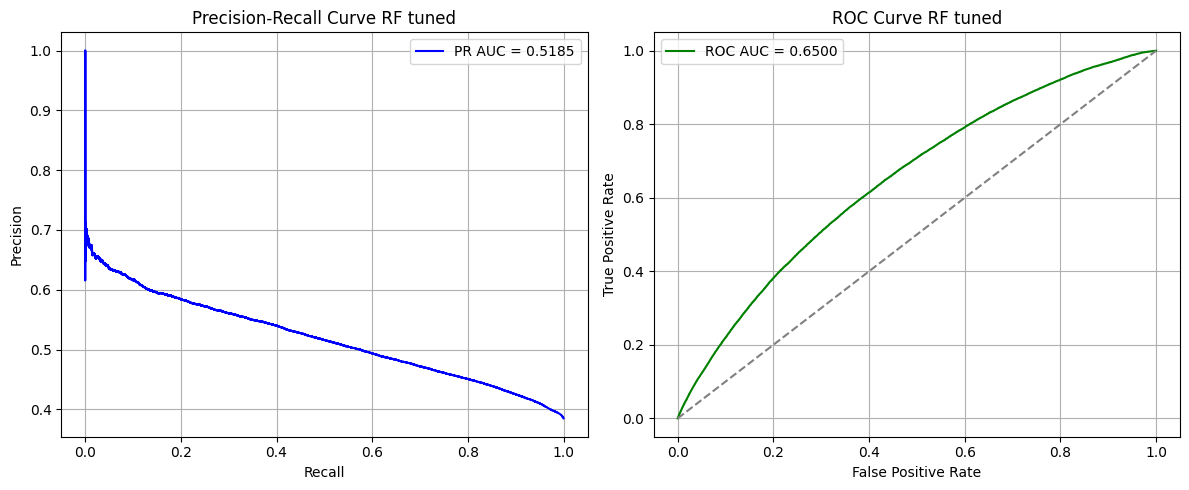

In [14]:
# Create pipeline with preprocessing steps
rf_pipe = make_pipe(rf, scale=True, use_smote=True, use_pca=False)

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

# GridSearch with TimeSeriesSplit
rf_grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=CV_CUSTOM_SPLITS,
    scoring='roc_auc',
    verbose=2,
    return_train_score=True
)

# Fit the final model on full training set
rf_grid_search.fit(X_train_sorted, y_train_sorted)
rf_grid_search_best_params = rf_grid_search.best_params_
# Results
print("Best Params:", rf_grid_search_best_params)
print("Best Score:", rf_grid_search.best_score_)

rf_pipe_tuned = rf_grid_search.best_estimator_

y_probs_rf_tuned = rf_pipe_tuned.predict_proba(X_test_sorted)[:, 1]

get_eval_metrics(y_test_sorted, y_probs_rf_tuned, "RF tuned", target_recall=0.75)

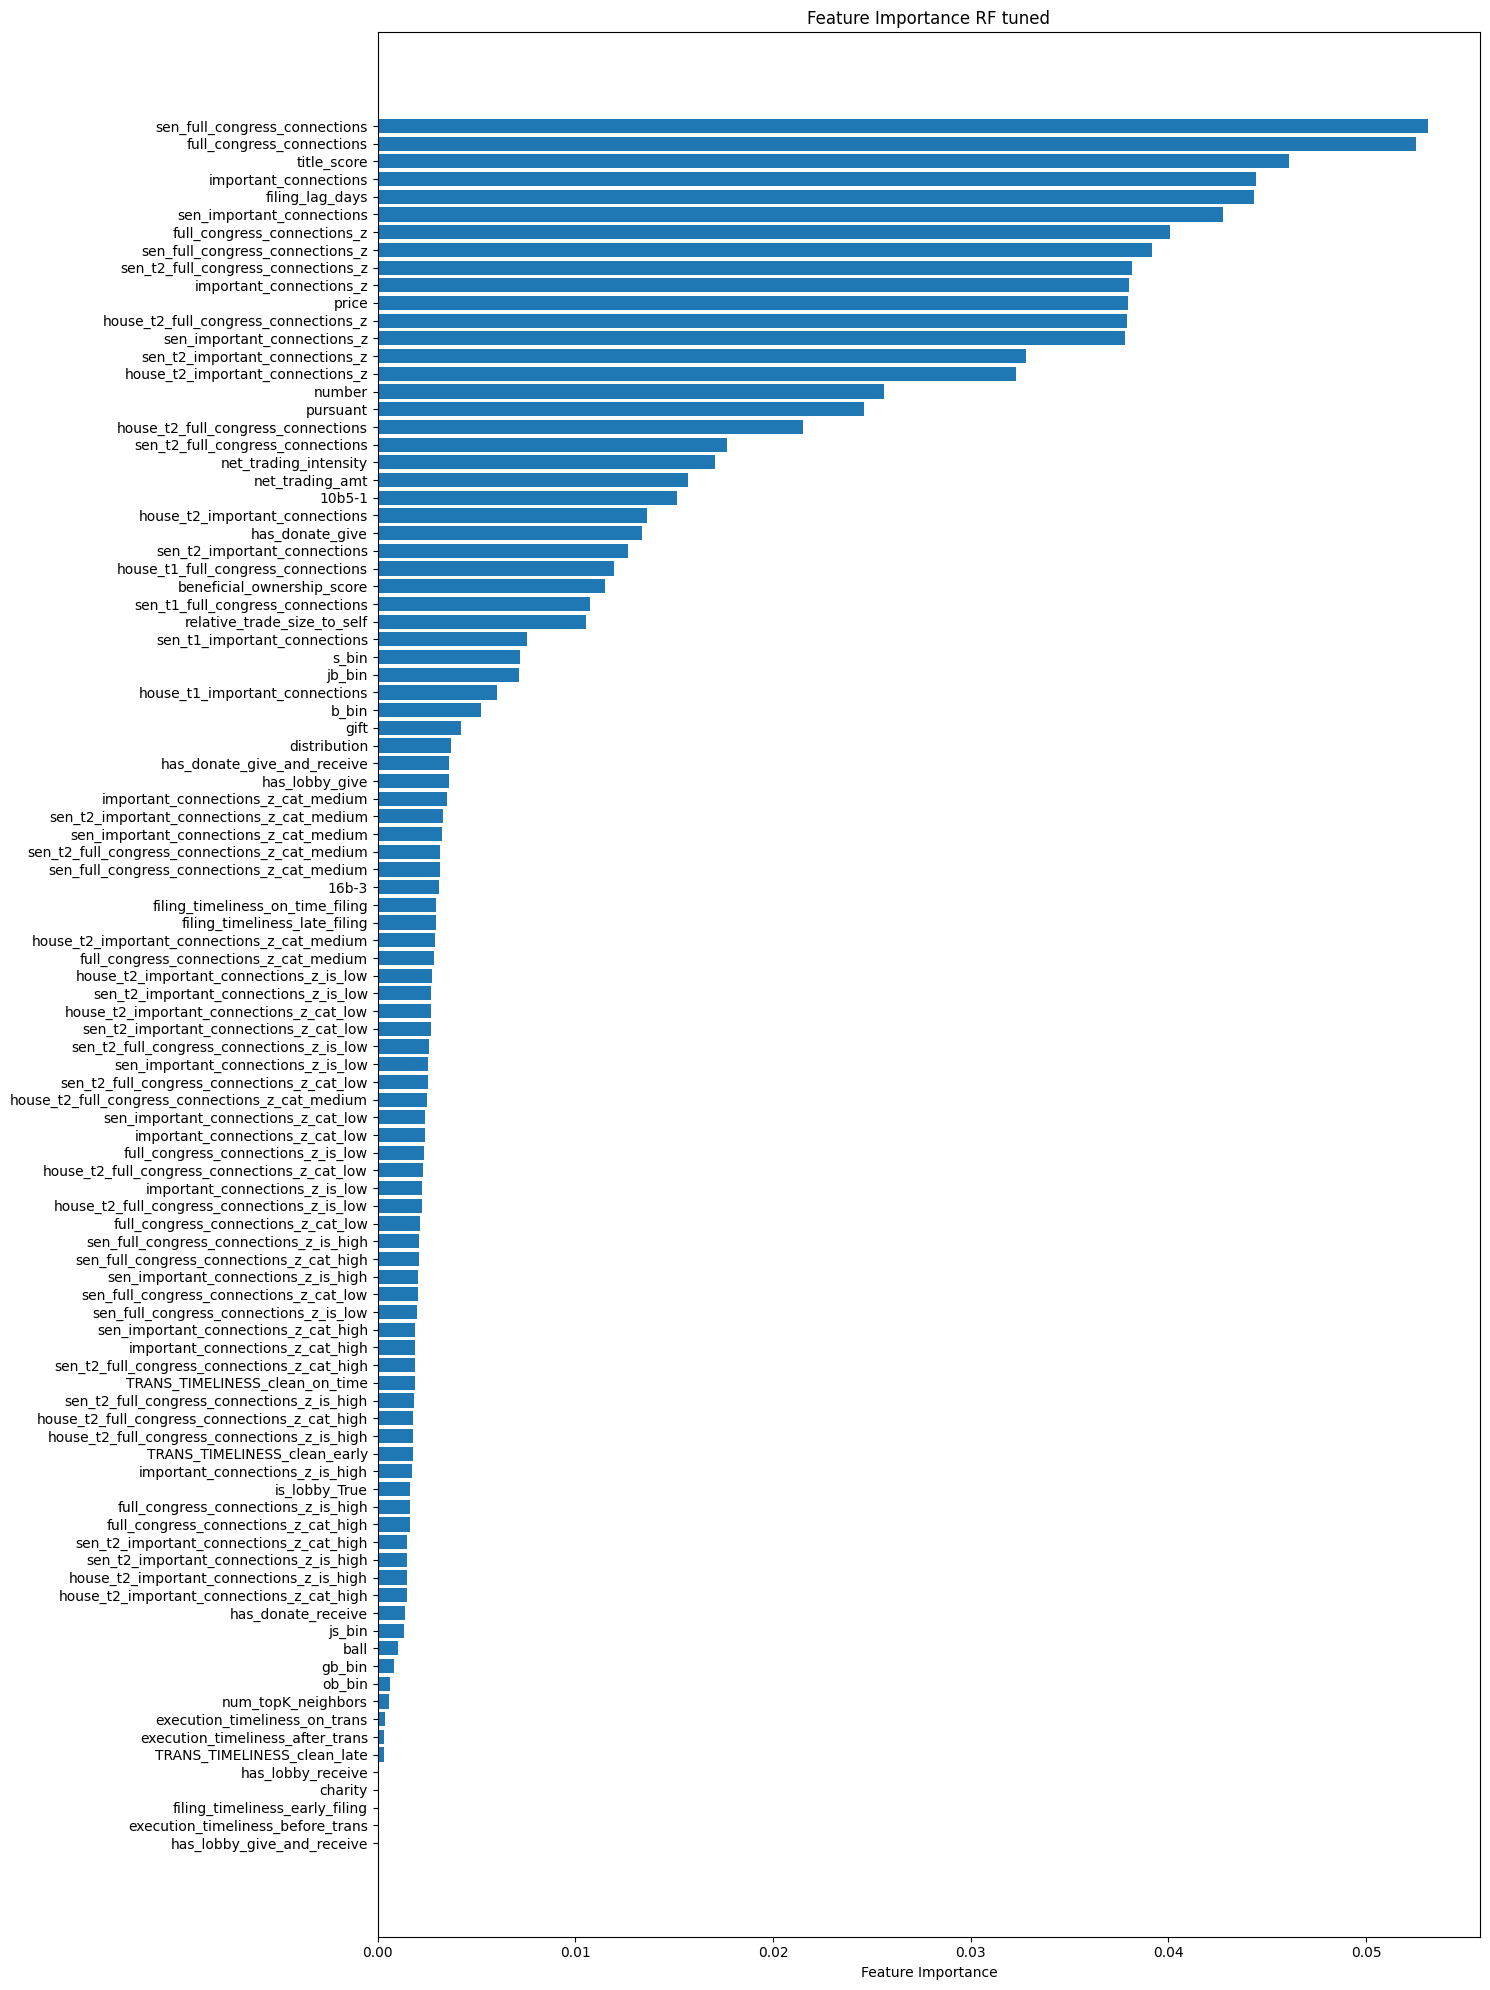

In [15]:
plot_feature_importance(rf_pipe_tuned, X_test, title="RF tuned")

___
## 2.2 Hyperparameter tuning: MLP
___

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Iteration 1, loss = 0.64634561
Validation score: 0.629179
Iteration 2, loss = 0.62762210
Validation score: 0.643105
Iteration 3, loss = 0.61833028
Validation score: 0.652235
Iteration 4, loss = 0.61331753
Validation score: 0.655560
Iteration 5, loss = 0.61021051
Validation score: 0.656418
Iteration 6, loss = 0.60792926
Validation score: 0.660144
Iteration 7, loss = 0.60633660
Validation score: 0.661510
Iteration 8, loss = 0.60521568
Validation score: 0.663459
Iteration 9, loss = 0.60417551
Validation score: 0.664722
Iteration 10, loss = 0.60336476
Validation score: 0.666410
Iteration 11, loss = 0.60262475
Validation score: 0.667891
Iteration 12, loss = 0.60203721
Validation score: 0.668520
Iteration 13, loss = 0.60153892
Validation score: 0.668660
Iteration 14, loss = 0.60117220
Validation score: 0.668749
Iteration 15, loss = 0.60074255
Validation score: 0.669055
Iteration 16, loss = 0.60023723
Validation score: 0.669424
Ite

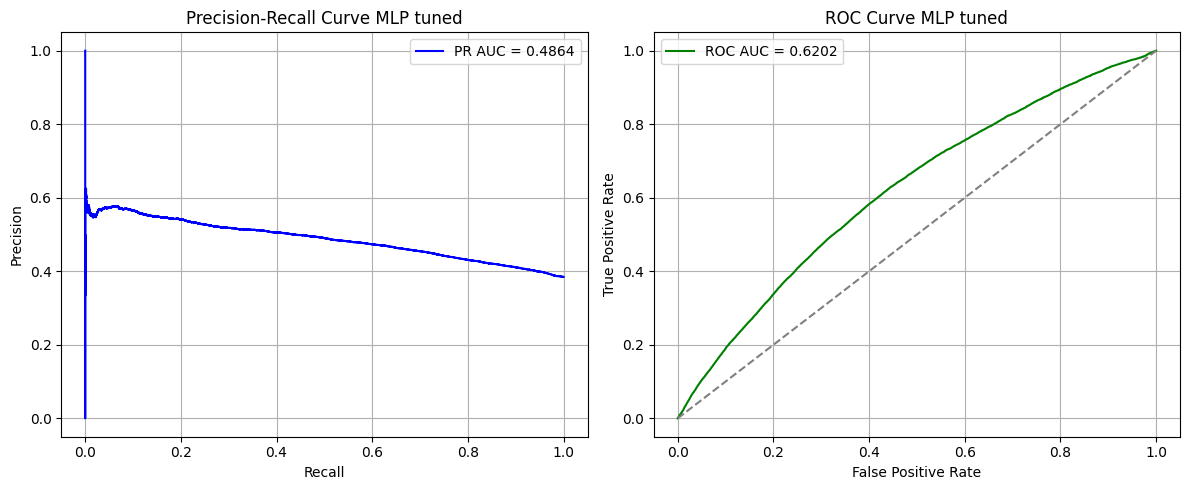

In [16]:
# Parameter grid for tuning
param_grid = {
    'clf__hidden_layer_sizes': [(50,), 
                                (100,), 
                                (128, 64),
                                (100, 50),
                                (100, 50, 25)],
    'clf__alpha': [0.0001, 0.001],
    'clf__learning_rate_init': [0.001, 0.01],
    'clf__solver': ['adam'],  
}

# Grid search
mlp_grid_search = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=param_grid,
    cv=CV_CUSTOM_SPLITS,
    scoring='roc_auc', 
    verbose=2,
    n_jobs=-1
)

# Fit to your training data
mlp_grid_search.fit(X_train_sorted, y_train_sorted)
# Results
print("Best Params:", mlp_grid_search.best_params_)
print("Best Score:", mlp_grid_search.best_score_)

# Get best model
mlp_tuned = mlp_grid_search.best_estimator_

# -----------------------------------------------------------------------------
# Predict probabilities
# -----------------------------------------------------------------------------
y_probs_mlp_tuned = mlp_tuned.predict_proba(X_test_sorted)[:, 1]

get_eval_metrics(y_test_sorted, y_probs_mlp_tuned, "MLP tuned", target_recall=0.75)

Computing permutation importance
Top 10 features by permutation importance:
                                    feature  importance       std
7                 sen_important_connections    0.015779  0.000192
56                              title_score    0.009601  0.000251
62                          has_donate_give    0.007934  0.000319
40                                   jb_bin    0.007594  0.000248
39                                    b_bin    0.005097  0.000442
69  sen_full_congress_connections_z_cat_low    0.004855  0.000149
47                                   number    0.004093  0.000569
50                                   10b5-1    0.003699  0.000247
23   sen_full_congress_connections_z_is_low    0.003195  0.000189
29       sen_important_connections_z_is_low    0.002604  0.000144


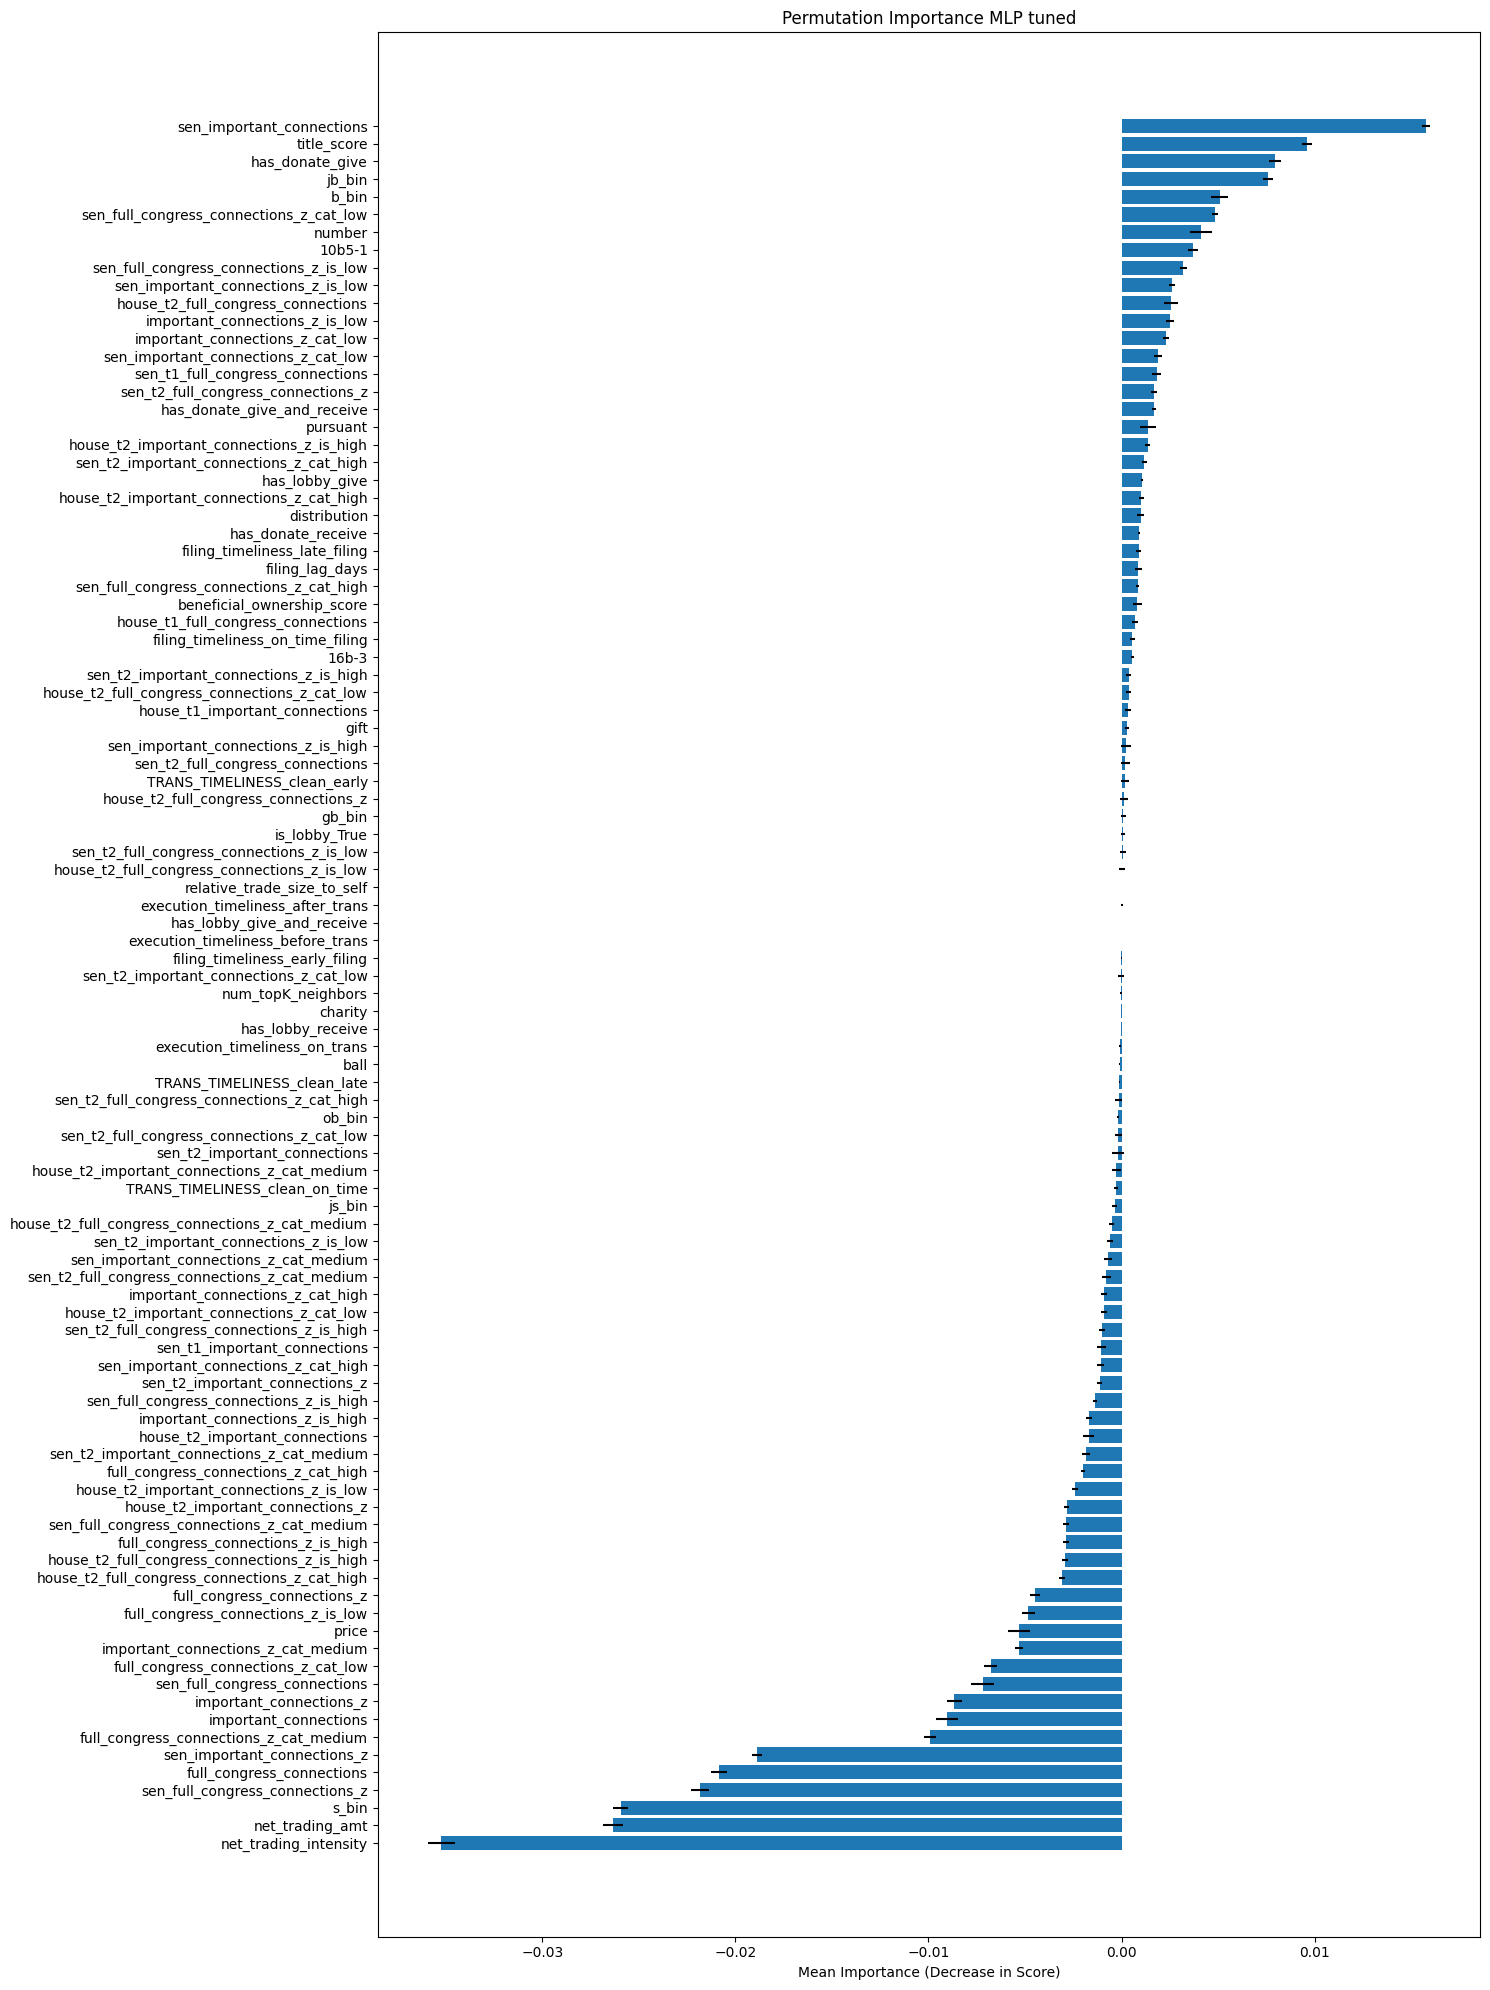

In [17]:
plot_permutation_importance(mlp_tuned, X_test_sorted, y_test_sorted, "MLP tuned")

___
# 3. Feature Selection
___

In [18]:
columns = ['jb_bin', 'b_bin', 'ob_bin', 'has_lobby_receive',
       'filing_timeliness_early_filing', 'js_bin',
       'has_donate_give_and_receive',
       'house_t2_full_congress_connections_z_cat_medium',
       'house_t2_full_congress_connections_z_is_high', 'gb_bin',
       'net_trading_amt', 'has_donate_receive', 'num_topK_neighbors', 'ball',
       'full_congress_connections_z_is_low', 'important_connections_z_cat_low',
       'TRANS_TIMELINESS_clean_late', 'has_lobby_give', 'charity',
       'important_connections_z_cat_high', 'gift',
       'sen_t2_full_congress_connections_z_cat_high',
       'sen_full_congress_connections_z_cat_medium',
       'sen_t2_important_connections_z_cat_medium',
       'house_t2_important_connections_z_is_low', 'has_donate_give',
       'sen_full_congress_connections_z_cat_high', 'is_lobby_True', '16b-3',
       'execution_timeliness_after_trans', 'TRANS_TIMELINESS_clean_early',
       'sen_t2_important_connections_z_is_high',
       'sen_full_congress_connections_z', 'sen_t2_important_connections_z',
       'sen_t2_full_congress_connections_z_cat_medium']

X_train_dropped = X_train[columns]
X_test_dropped = X_test[columns]
X_train_sorted_dropped = X_train_sorted[columns]
X_test_sorted_dropped = X_test_sorted[columns]

___
## 3.1 Feature Selection: Random Forest
___

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=   2.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time= 1.2min
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  20.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  13.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=100; total time=  17.6s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=200; total time=   4.7s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf__n_estimators=200; total time= 2.2min
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_split=2, clf_

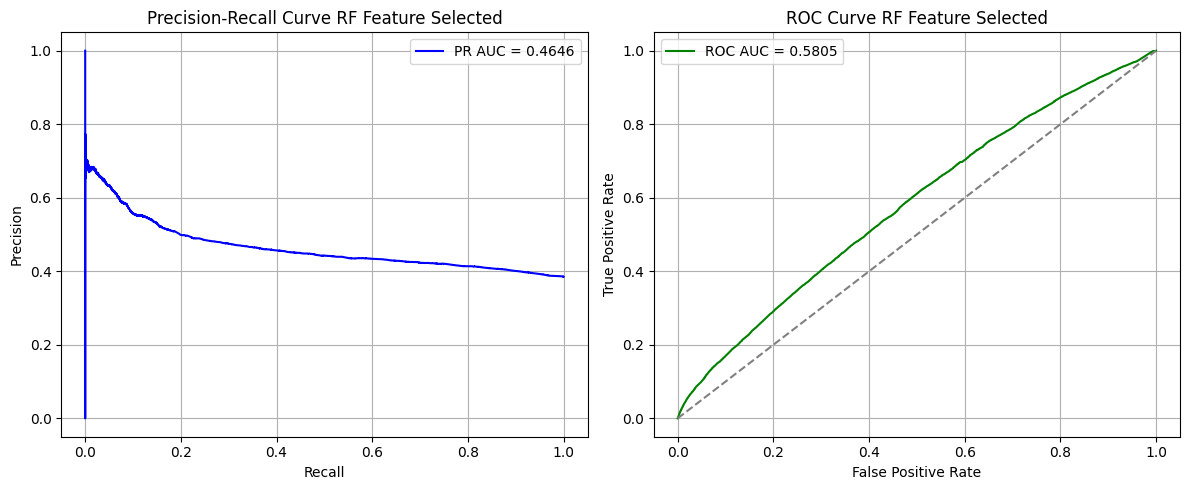

In [19]:
# -----------------------------------------------------------------------------
# Train RF Using grid search as define previously
# -----------------------------------------------------------------------------
rf_grid_search.fit(X_train_dropped, y_train)

rf_pipe_tuned_fs = rf_grid_search.best_estimator_

print("Best Params:", rf_grid_search_best_params)
print("Best Score:", rf_grid_search.best_score_)

y_probs_rf_tuned_fs = rf_pipe_tuned_fs.predict_proba(X_test_dropped)[:, 1]

get_eval_metrics(y_test, y_probs_rf_tuned_fs, "RF Feature Selected", target_recall=0.75)

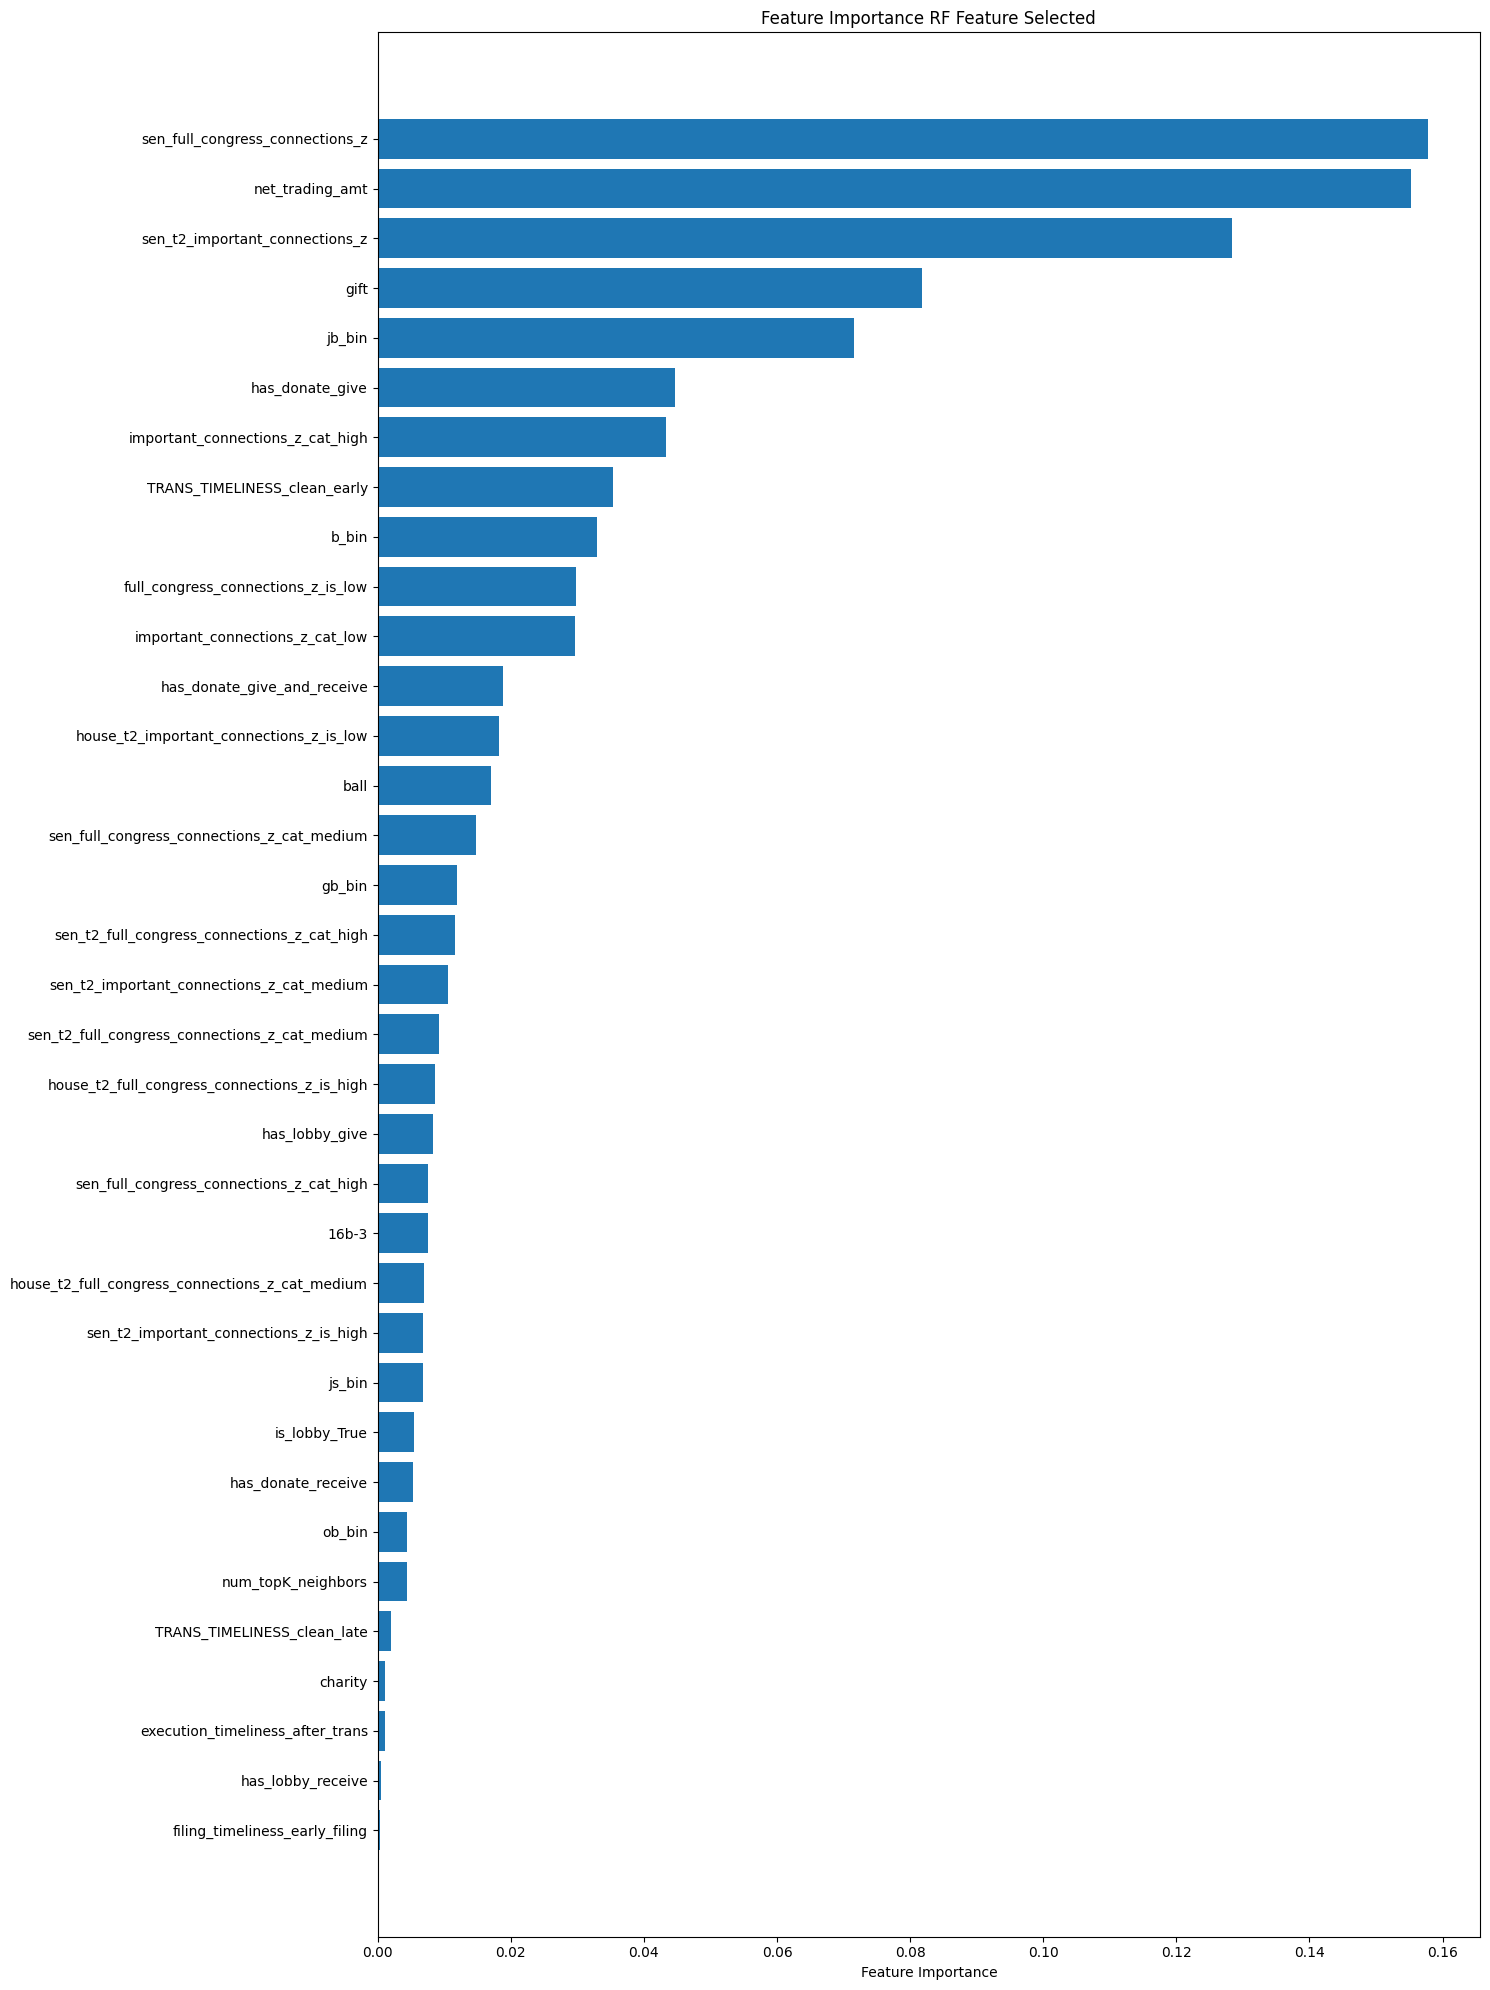

In [20]:
plot_feature_importance(rf_pipe_tuned_fs, X_test_dropped, title="RF Feature Selected")

___
## 3.2 Feature Selection: MLP
___

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Iteration 1, loss = 0.69381214
Validation score: 0.504082
Iteration 2, loss = 0.69311840
Validation score: 0.505921
Iteration 3, loss = 0.69298681
Validation score: 0.508447
Iteration 4, loss = 0.69287491
Validation score: 0.508457
Iteration 5, loss = 0.69273902
Validation score: 0.509699
Iteration 6, loss = 0.69255808
Validation score: 0.509605
Iteration 7, loss = 0.69247048
Validation score: 0.509299
Iteration 8, loss = 0.69237961
Validation score: 0.508992
Iteration 9, loss = 0.69227483
Validation score: 0.510556
Iteration 10, loss = 0.69219103
Validation score: 0.510458
Iteration 11, loss = 0.69211407
Validation score: 0.510530
Iteration 12, loss = 0.69201446
Validation score: 0.511996
Iteration 13, loss = 0.69193614
Validation score: 0.511424
Iteration 14, loss = 0.69192176
Validation score: 0.511793
Iteration 15, loss = 0.69185821
Validation score: 0.511419
Iteration 16, loss = 0.69179894
Validation score: 0.510790
Ite

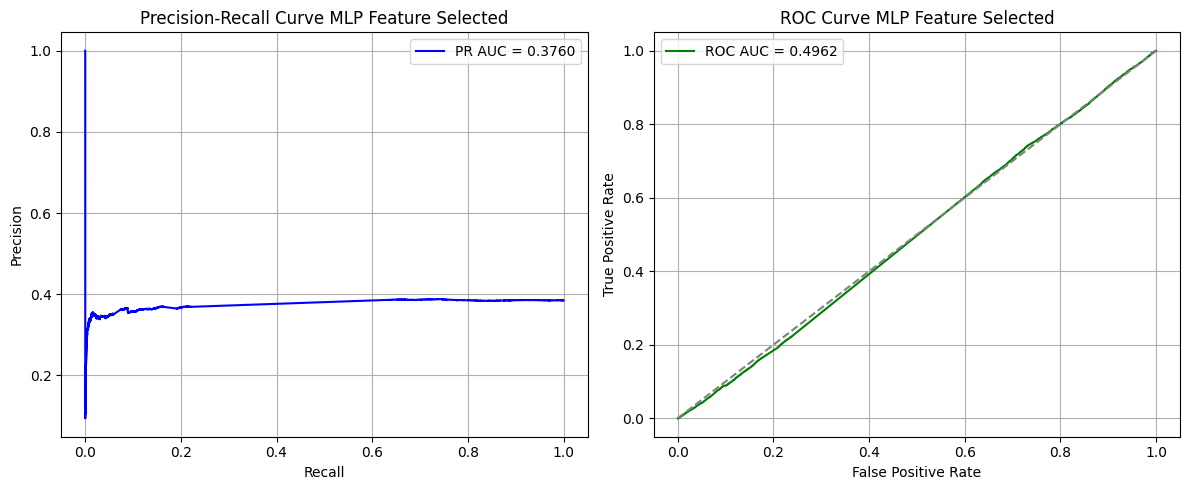

In [21]:
# -----------------------------------------------------------------------------
# Train MLP Using grid search as define previously
# -----------------------------------------------------------------------------
mlp_grid_search.fit(X_train_sorted_dropped, y_train)

mlp_pipe_tuned_fs = mlp_grid_search.best_estimator_
# Results
print("Best Params:", mlp_grid_search.best_params_)
print("Best Score:", mlp_grid_search.best_score_)

y_probs_mlp_tuned_fs = mlp_pipe_tuned_fs.predict_proba(X_test_sorted_dropped)[:, 1]

get_eval_metrics(y_test_sorted, y_probs_mlp_tuned_fs, "MLP Feature Selected", target_recall=0.75)

Computing permutation importance
Top 10 features by permutation importance:
                                         feature  importance       std
14            full_congress_connections_z_is_low    0.030013  0.000354
25                               has_donate_give    0.011711  0.000324
32               sen_full_congress_connections_z    0.011478  0.000352
21   sen_t2_full_congress_connections_z_cat_high    0.009231  0.000214
22    sen_full_congress_connections_z_cat_medium    0.006460  0.000216
8   house_t2_full_congress_connections_z_is_high    0.006285  0.000216
33                sen_t2_important_connections_z    0.004813  0.000256
24       house_t2_important_connections_z_is_low    0.003759  0.000358
26      sen_full_congress_connections_z_cat_high    0.003310  0.000202
23     sen_t2_important_connections_z_cat_medium    0.001972  0.000333


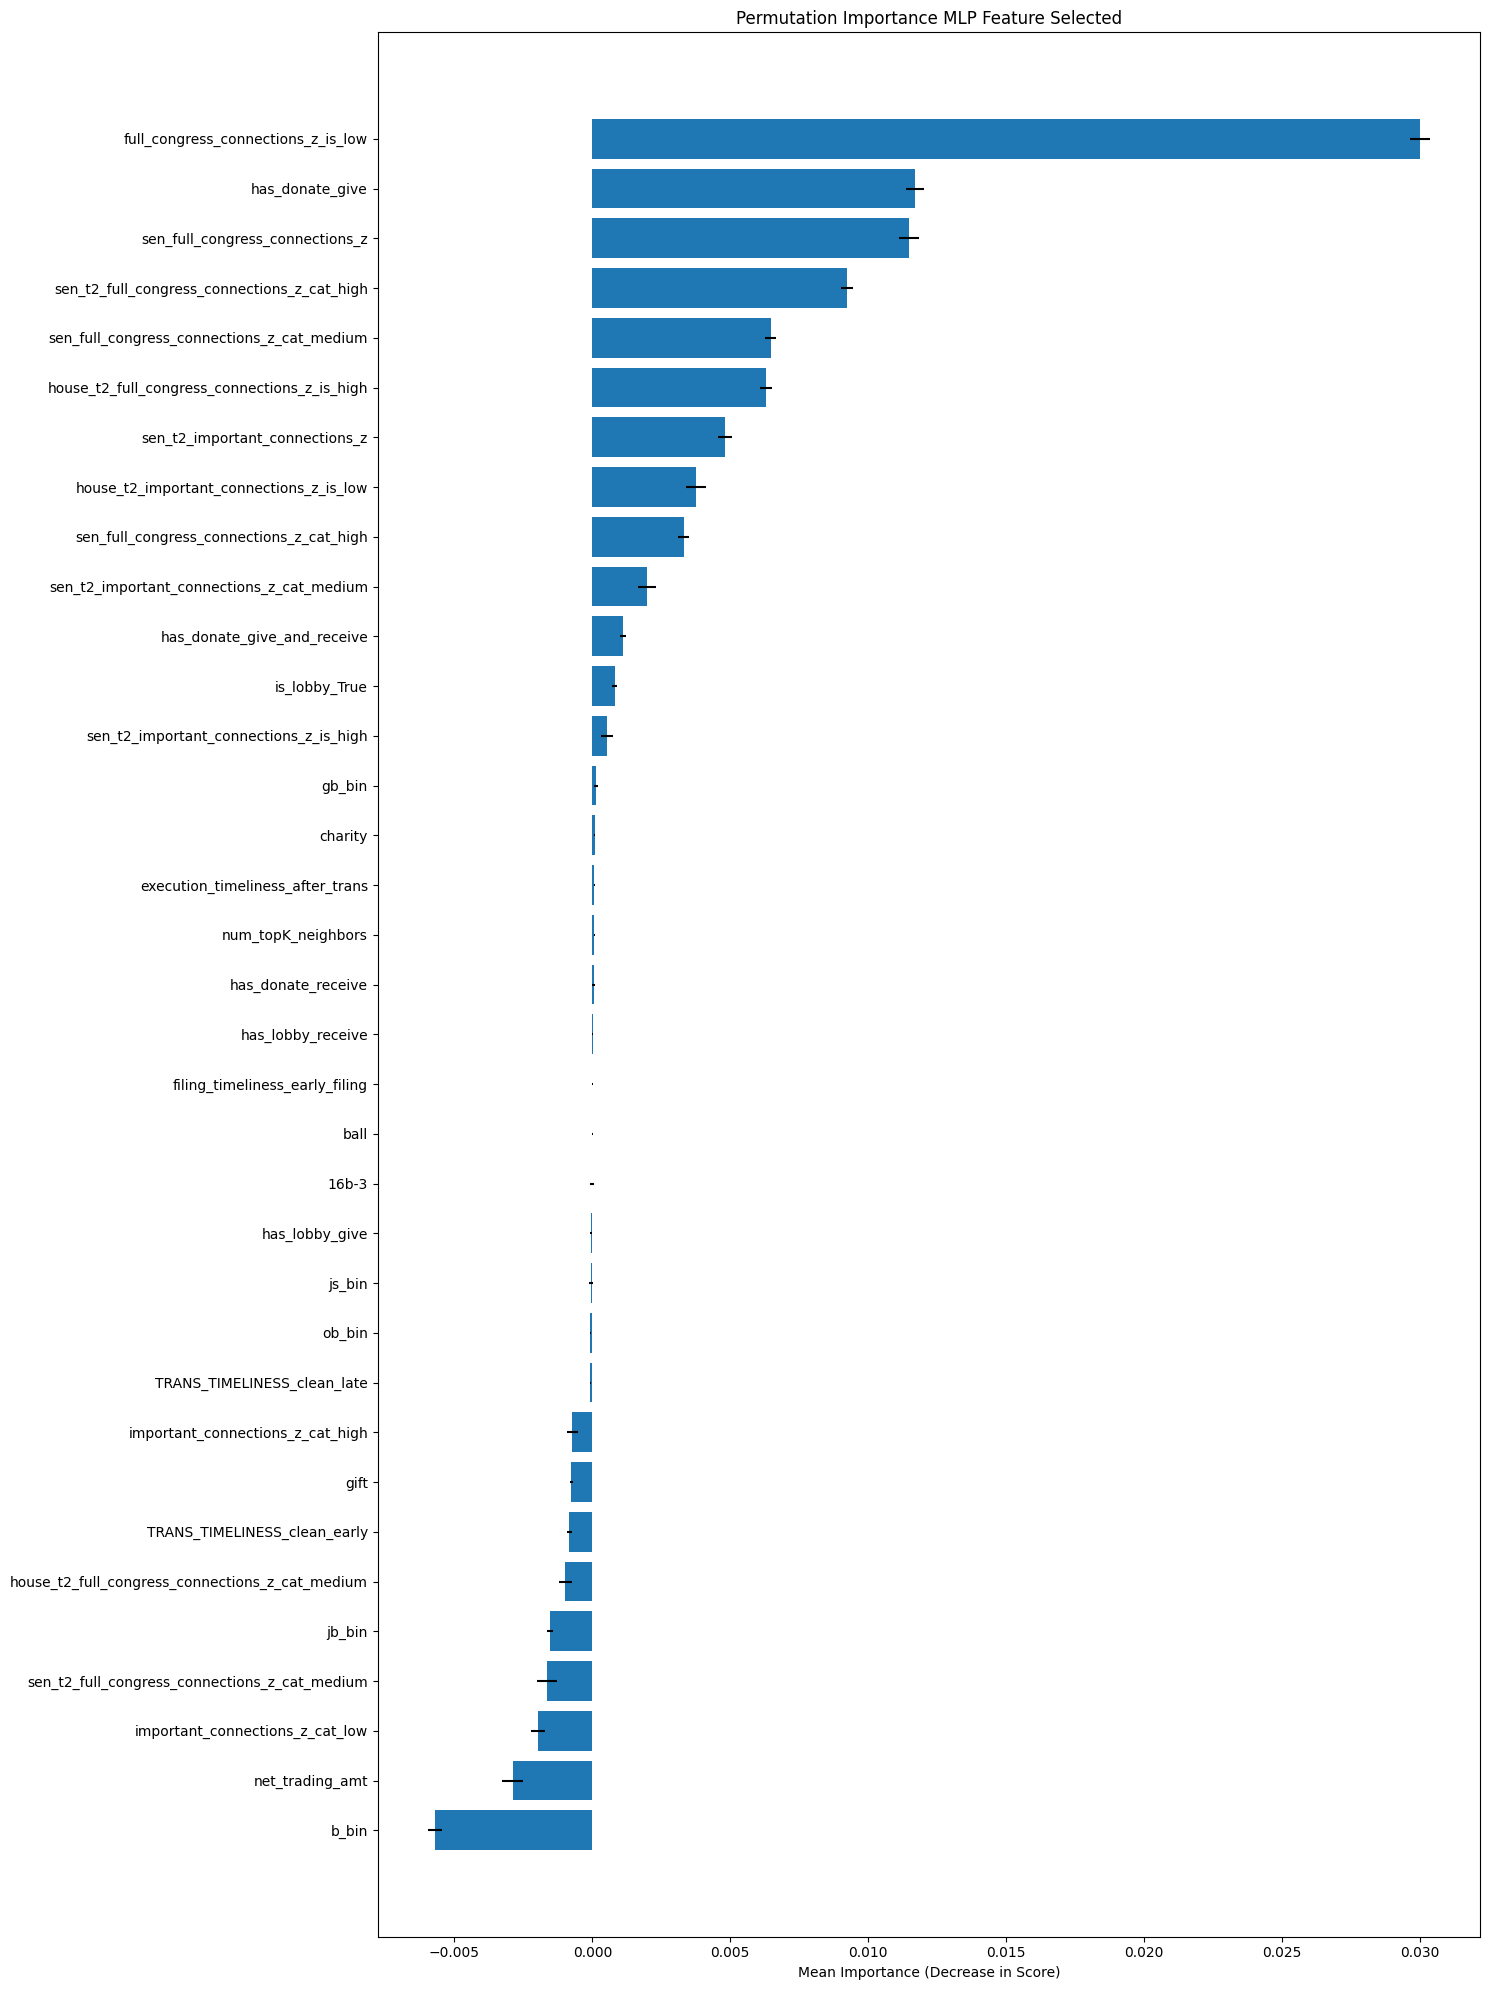

In [22]:
plot_permutation_importance(mlp_pipe_tuned_fs, X_test_sorted_dropped, y_test_sorted, "MLP Feature Selected")

___
# 4. Time Cut
___

In [9]:
# re read full data just in case
df_train = pd.read_csv(TESTING_FEATURES_FILE,parse_dates=['TRANS_DATE'])
df_test = pd.read_csv(TRAINING_FEATURES_FILE,parse_dates=['TRANS_DATE'])
print(df_train.shape)
print(df_test.shape)

df_train = df_train.drop(columns = COLS_TO_DROP )
df_test = df_test.drop(columns = COLS_TO_DROP )

# Filter for a shorter period
df_train_cut = df_train[df_train['TRANS_DATE'].dt.year > 2010] 
df_test_cut = df_test[df_test['TRANS_DATE'].dt.year < 2020] 
print("Keeping years after 2010: ", df_train_cut.shape)
print("Keeping years before 2020, ",df_test_cut.shape)

if RUN_ON_SUBSET:
    df_train_cut = df_train_cut.sample(n=1000, random_state=5)  # Set random_state for reproducibility
    df_test_cut = df_test_cut.sample(n=100, random_state=5)  # Set random_state for reproducibility

X_train_cut, y_train_cut = df_train_cut.drop(columns = [LABEL] + ['TRANS_DATE']), df_train_cut[LABEL]
X_test_cut, y_test_cut = df_test_cut.drop(columns = [LABEL] + ['TRANS_DATE']), df_test_cut[LABEL]

# have a sorted version
df_train_cut_sorted = df_train_cut.sort_values(by='TRANS_DATE', ascending=True).reset_index(drop=True)
df_test_cut_sorted = df_test_cut.sort_values(by='TRANS_DATE', ascending=True).reset_index(drop=True)

X_train_sorted_date = df_train_cut_sorted.drop(columns = [LABEL])
CV_CUSTOM_SPLITS = list(splitter.split(X_train_sorted_date))  # list of (train_idx, val_idx)

X_train_cut_sorted, y_train_cut_sorted = df_train_cut_sorted.drop(columns = [LABEL] + ['TRANS_DATE']), df_train_cut_sorted[LABEL]
X_test_cut_sorted, y_test_cut_sorted = df_test_cut_sorted.drop(columns = [LABEL] + ['TRANS_DATE']), df_test_cut_sorted[LABEL]



(1417896, 111)
(347020, 111)
Keeping years after 2010:  (481880, 100)
Keeping years before 2020,  (186099, 100)


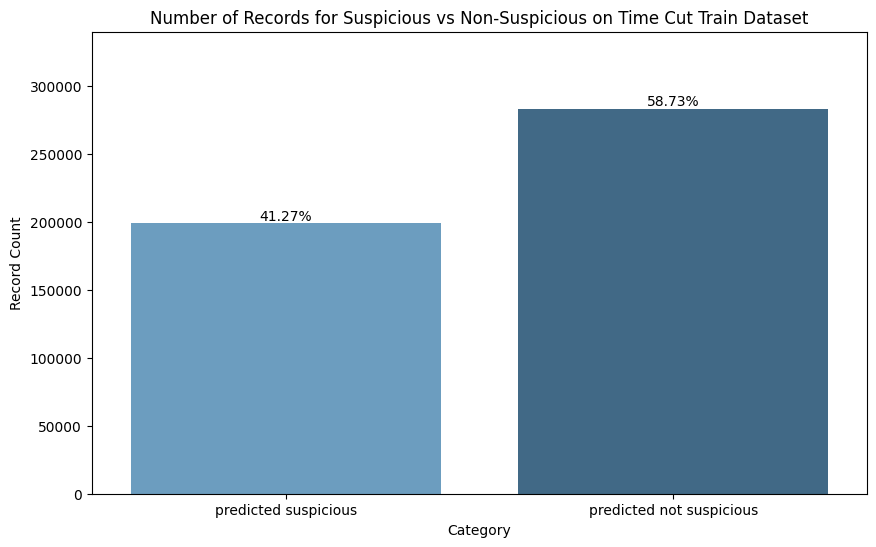

In [10]:
count1, count0 = sum(df_train_cut[LABEL] == 1), sum(df_train_cut[LABEL] == 0)

categories = ["predicted suspicious", "predicted not suspicious"]
value = [count1, count0]

plt.figure(figsize=(10,6))
# Create the barplot
ax = sns.barplot(x=categories, y=value, palette="Blues_d")
# Add percentage labels on top of the bars
for i, v in enumerate(value):
    ax.text(i, v + 0.01, f"{(v*100)/df_train_cut.shape[0]:1.2f}%", ha='center', va='bottom')
plt.ylim(0, max(value) * 1.2)
plt.xlabel('Category')
plt.ylabel('Record Count')
plt.title('Number of Records for Suspicious vs Non-Suspicious on Time Cut Train Dataset')
plt.show()

___
## 4.1 Time Cut: Random Forest
___

Best Params: {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best Score: 0.619749195876642
Best threshold for recall 0.75: 0.4824

=== Classification Report ===

Threshold for recall=0.75 ⇒ 0.482
              precision    recall  f1-score   support

           0      0.711     0.494     0.583    103106
           1      0.544     0.750     0.631     82993

    accuracy                          0.608    186099
   macro avg      0.627     0.622     0.607    186099
weighted avg      0.636     0.608     0.604    186099

Area under PR curvere: 0.597
Average precision score: 0.597
Area under ROC curve 0.67


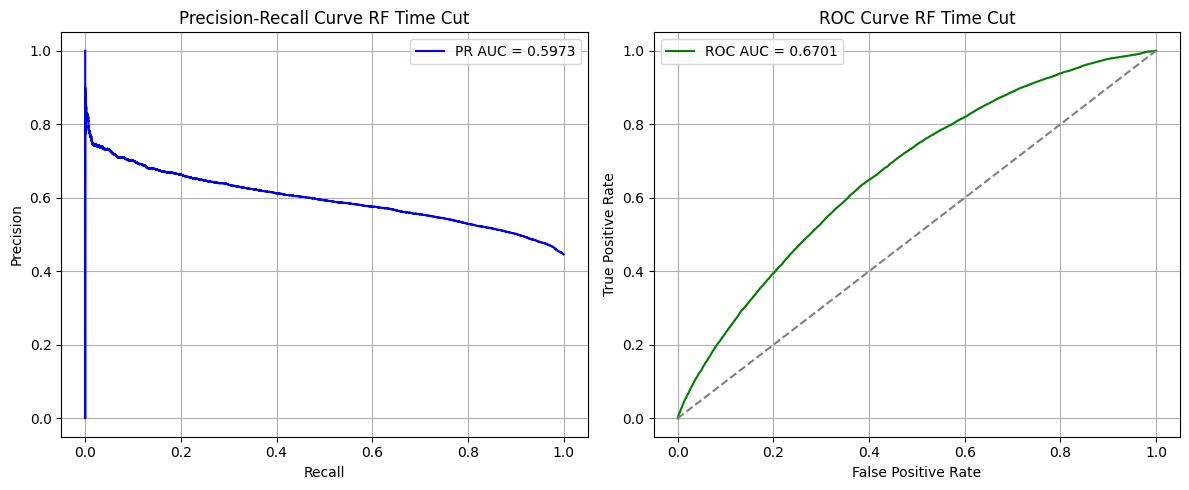

In [17]:
# -----------------------------------------------------------------------------
# Train RF Using grid search as defined previously but redefine here
# -----------------------------------------------------------------------------

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create pipeline with preprocessing steps
rf_pipe = make_pipe(rf, scale=True, use_smote=True, use_pca=False)

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

# GridSearch with TimeSeriesSplit
rf_grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=CV_CUSTOM_SPLITS,
    scoring='roc_auc',
    verbose=2,
    return_train_score=True
)

rf_grid_search.fit(X_train_cut, y_train_cut)

rf_pipe_tuned_tc = rf_grid_search.best_estimator_
print("Best Params:", rf_grid_search.best_params_)
print("Best Score:", rf_grid_search.best_score_)

y_probs_rf_tuned_tc = rf_pipe_tuned_tc.predict_proba(X_test_cut)[:, 1]

get_eval_metrics(y_test_cut, y_probs_rf_tuned_tc, "RF Time Cut", target_recall=0.75)

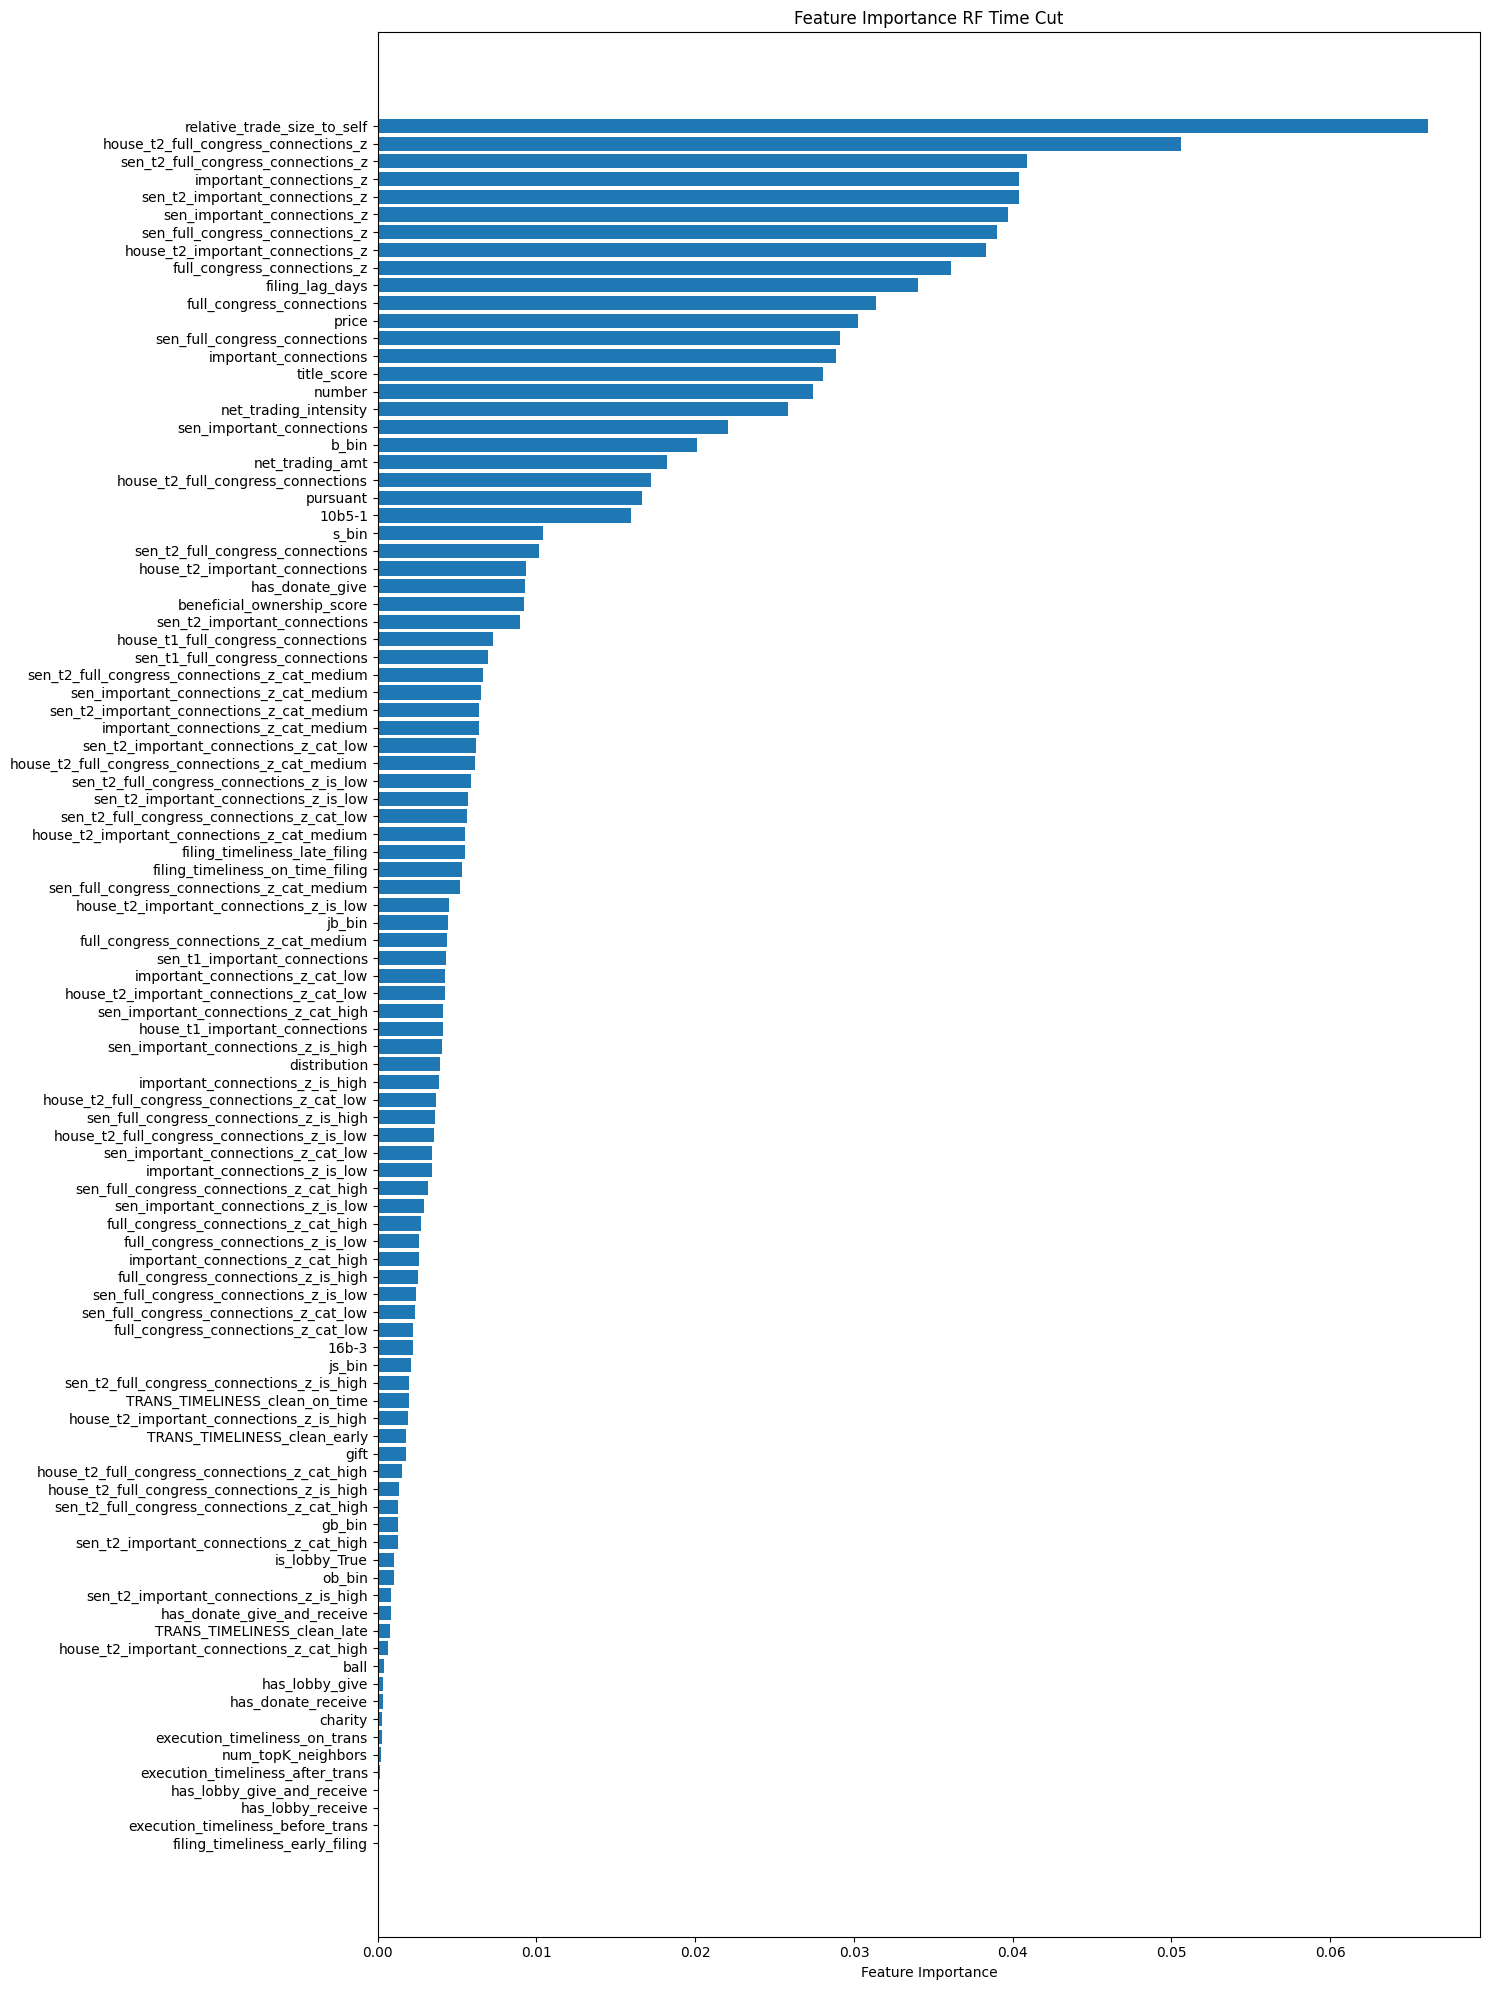

In [ ]:
plot_feature_importance(rf_pipe_tuned_tc, X_test_cut, title="RF Time Cut")

___
## 4.2 Time Cut: MLP
___

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Iteration 1, loss = 0.66014750
Validation score: 0.616260
Iteration 2, loss = 0.64060159
Validation score: 0.629456
Iteration 3, loss = 0.63229060
Validation score: 0.636346
Iteration 4, loss = 0.62652266
Validation score: 0.641275
Iteration 5, loss = 0.62206410
Validation score: 0.643819
Iteration 6, loss = 0.61842981
Validation score: 0.646734
Iteration 7, loss = 0.61542275
Validation score: 0.649154
Iteration 8, loss = 0.61275391
Validation score: 0.651221
Iteration 9, loss = 0.61040307
Validation score: 0.654030
Iteration 10, loss = 0.60834646
Validation score: 0.654436
Iteration 11, loss = 0.60652043
Validation score: 0.656397
Iteration 12, loss = 0.60487327
Validation score: 0.657421
Iteration 13, loss = 0.60336524
Validation score: 0.658340
Iteration 14, loss = 0.60196041
Validation score: 0.659082
Iteration 15, loss = 0.60068276
Validation score: 0.660213
Iteration 16, loss = 0.59949267
Validation score: 0.660725
Iter

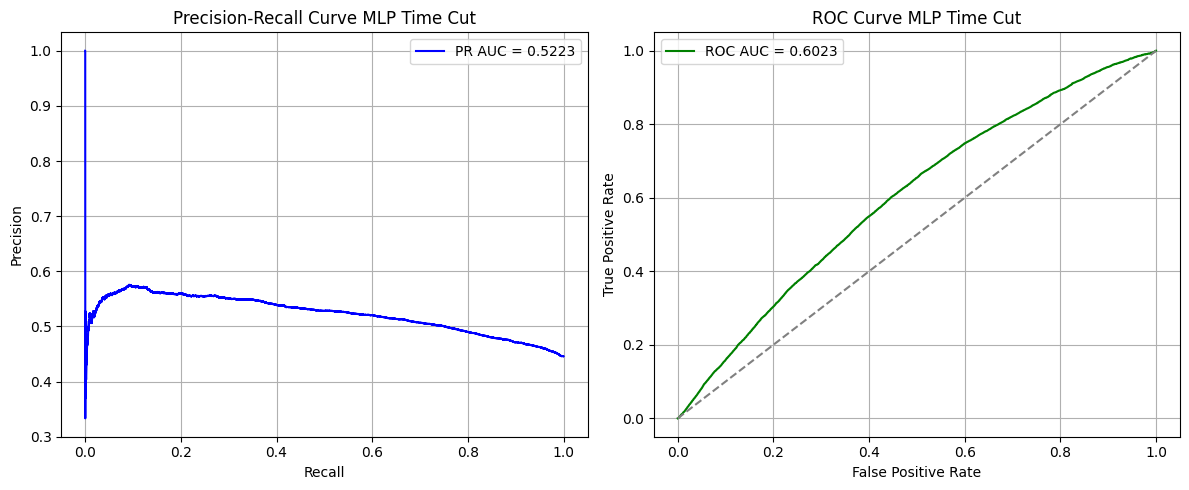

In [39]:
# -----------------------------------------------------------------------------
# Train MLP Using grid search as define previously
# -----------------------------------------------------------------------------
mlp_pipe = make_pipe(MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        batch_size=1024,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-3,
        random_state=0,
        verbose=True,
        shuffle=False, ), 
    use_smote=True,
    scale=True)


# Parameter grid for tuning
param_grid = {
    'clf__hidden_layer_sizes': [(50,), 
                                (100,), 
                                (128, 64),
                                (100, 50),
                                (100, 50, 25)],
    'clf__alpha': [0.0001, 0.001],
    'clf__learning_rate_init': [0.001, 0.01],
    'clf__solver': ['adam'],  
}

# Grid search
mlp_grid_search = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=param_grid,
    cv=CV_CUSTOM_SPLITS,
    scoring='roc_auc', 
    verbose=2,
    n_jobs=-1
)

mlp_grid_search.fit(X_train_cut_sorted, y_train_cut_sorted)

mlp_pipe_tuned_tc = mlp_grid_search.best_estimator_
# Results
print("Best Params:", mlp_grid_search.best_params_)
print("Best Score:", mlp_grid_search.best_score_)

y_probs_mlp_tuned_tc = mlp_pipe_tuned_tc.predict_proba(X_test_cut_sorted)[:, 1]

get_eval_metrics(y_test_cut_sorted, y_probs_mlp_tuned_tc, "MLP Time Cut", target_recall=0.75)

Computing permutation importance
Top 10 features by permutation importance:
                                       feature  importance       std
39                                       b_bin    0.030846  0.000497
7                    sen_important_connections    0.028322  0.000850
8                sen_full_congress_connections    0.019169  0.000796
23      sen_full_congress_connections_z_is_low    0.016541  0.000464
40                                      jb_bin    0.016244  0.000316
56                                 title_score    0.013689  0.000713
62                             has_donate_give    0.013450  0.000686
72  sen_t2_full_congress_connections_z_cat_low    0.012454  0.000268
69     sen_full_congress_connections_z_cat_low    0.010497  0.000444
13                 full_congress_connections_z    0.010005  0.000560


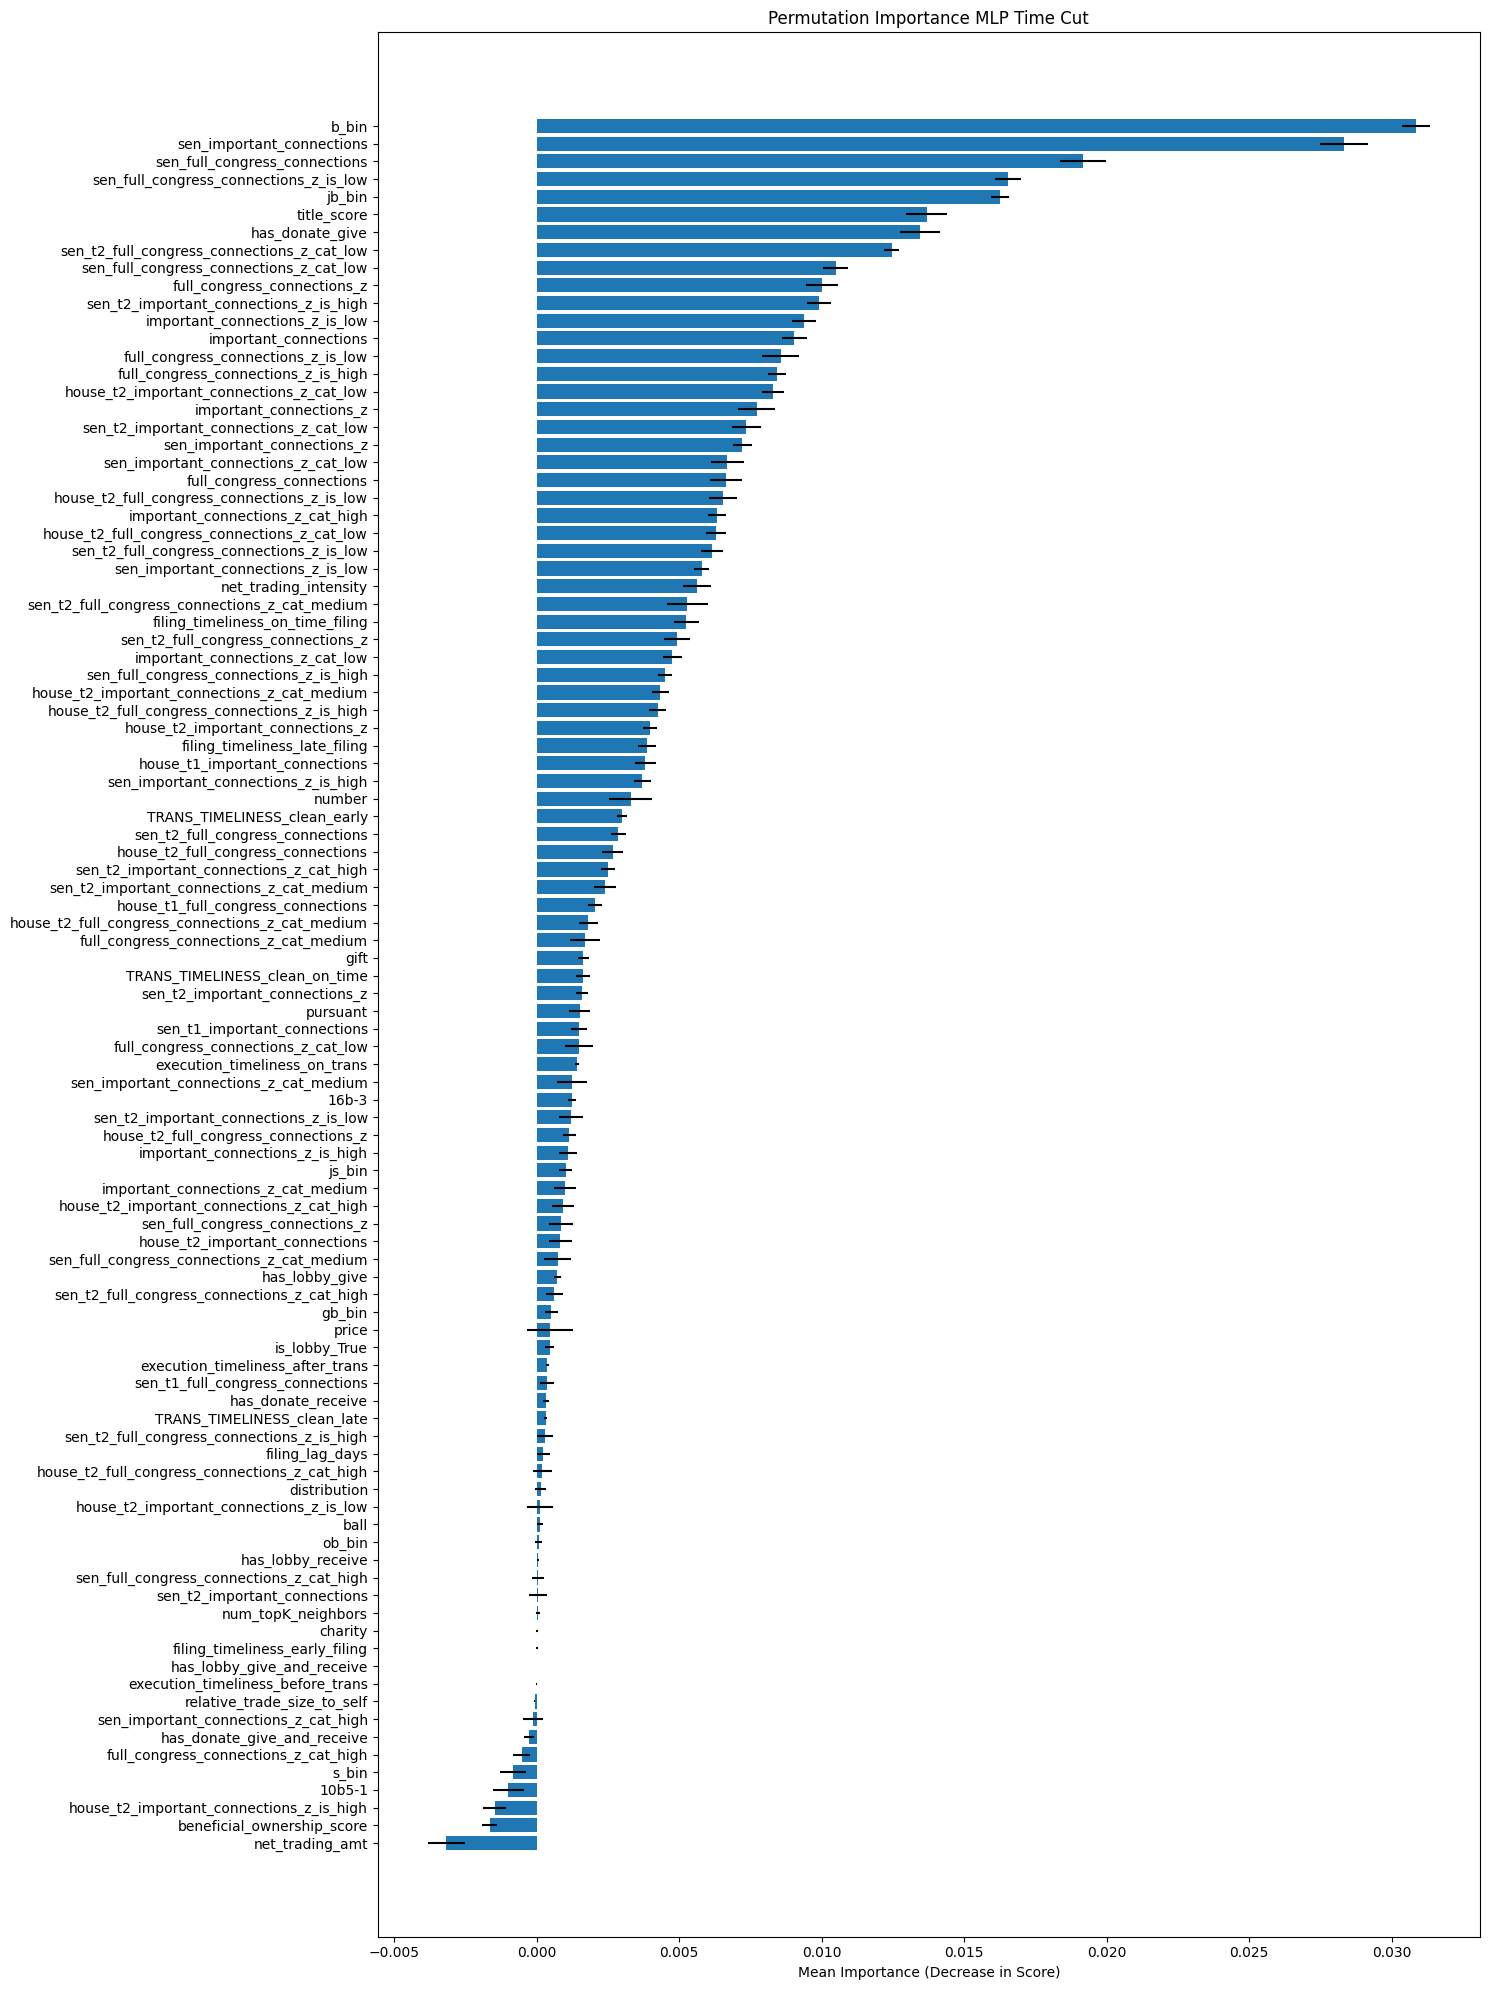

In [40]:
plot_permutation_importance(mlp_pipe_tuned_tc, X_test_cut_sorted, y_test_cut_sorted, "MLP Time Cut")

___
# Appendix
___

# KNN with PCA
- to see spread of variables 
- to efficiently see if KNN is a good model for our data

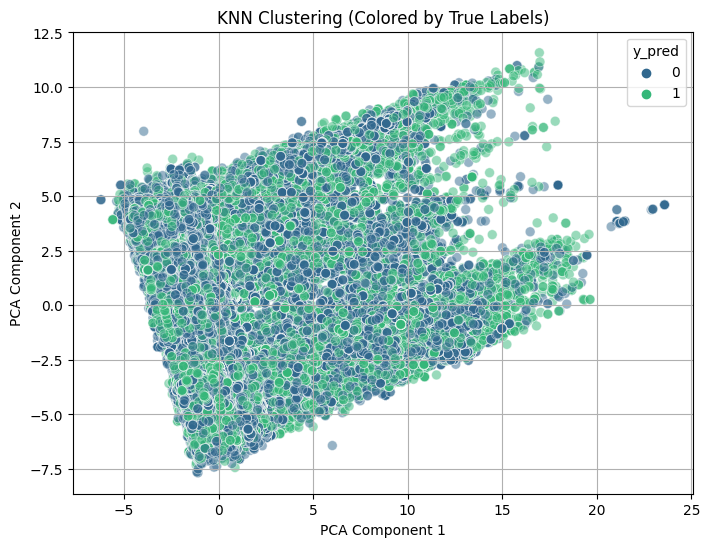

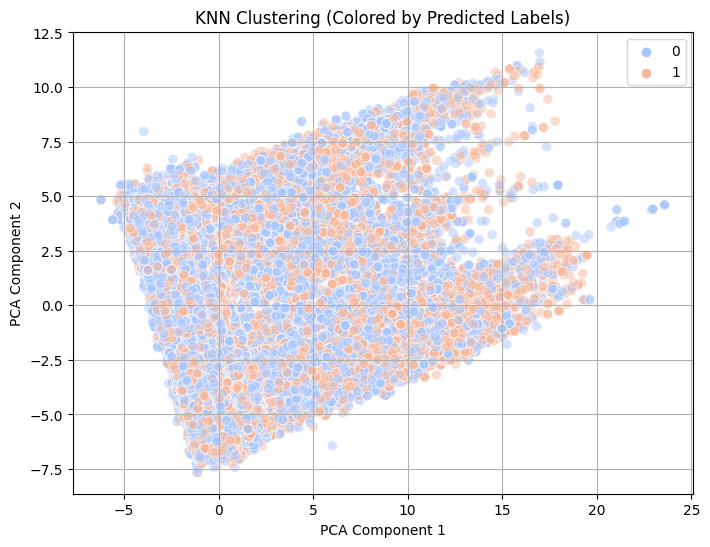

In [29]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_pipe_tuned = make_pipe(knn, scale=True, use_pca=True, pca_n=0.5)
knn_pipe_tuned.fit(X_train, y_train)

y_score_knn_tuned = knn_pipe_tuned.predict_proba(X_test)[:, 1]

# --- Extract PCA-transformed features from X_test ---
# Get the PCA step from the pipeline
pca_model = knn_pipe_tuned.named_steps["pca"]
X_test_scaled = knn_pipe_tuned.named_steps["scaler"].transform(X_test)
X_test_pca = pca_model.transform(X_test_scaled)

# --- Option 1: Color by True Labels ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], alpha = 0.5, hue=y_test, palette="viridis", s=50)
plt.title("KNN Clustering (Colored by True Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# --- Option 2: Color by Predicted Labels ---
y_pred_knn = knn_pipe_tuned.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], alpha = 0.5, hue=y_pred_knn, palette="coolwarm", s=50)
plt.title("KNN Clustering (Colored by Predicted Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
